# Predictor de precio de propiedades - Properati - Martín Savransky
## Introducción

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
#Cargamos los datos, dropeamos duplicados e imprimimos tamaño en pantalla
data = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv")
data = data.drop_duplicates()
data.shape

(144302, 19)

Agregamos columnas generadas por la aparición de ciertas palabras que describen las propiedades.
Usamos palabras clave:

`lista_palabras = ['jardin','cochera','parrilla','pileta','terraza','subte','lavadero','dependencia']`

In [3]:
#creamos nueva columna con palabras de descripción en una lista
data['desc_lista']=[x.lower().split(' ') for x in data['description']]

In [4]:
#creamos nuevos atributos suponiendo que si la palabra aparece en la descripcion entonces la propiedad cuenta con esa caracteristica
lista_palabras = ['jardin','cochera','parrilla','pileta','terraza','subte','lavadero','dependencia']
for palabra in lista_palabras:
  data[[palabra]] = data.apply(
    lambda row: sum(i == palabra for i in row['desc_lista'])>=1,
    axis=1)

In [5]:
#convertimos bool a int
for palabra in lista_palabras:
  data[[palabra]] = data[[palabra]].astype(int)

In [6]:
#chequeamos cantidades de propiedades para cada palabra
for palabra in ['cochera', 'pileta', 'terraza', 'subte', 'lavadero', 'dependencia','jardin', 'parrilla']:
    print(palabra, data[palabra].sum())

cochera 27573
pileta 12769
terraza 23475
subte 17908
lavadero 31902
dependencia 11103
jardin 3065
parrilla 17787


In [7]:
#Descartamos la columna auxiliar creada
data = data.drop(['desc_lista'],axis = 1)

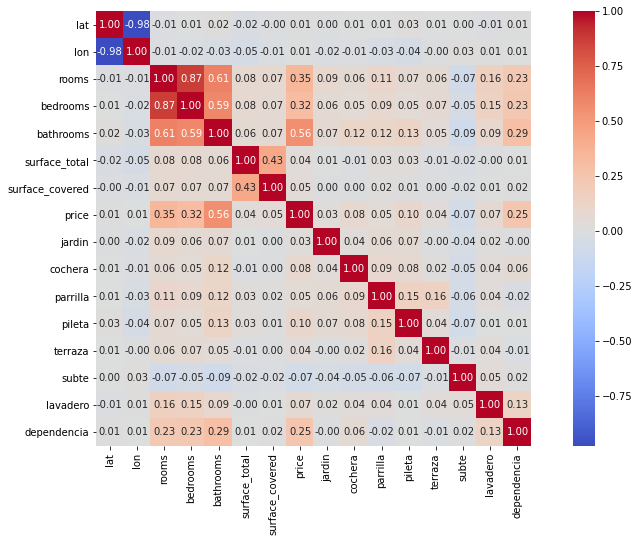

In [8]:
plt.rcParams['figure.figsize'] = (15,8)
corr = data.corr()
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           cmap= 'coolwarm')
plt.show()

In [9]:
data.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta,0,0,0,0,0,0,0,0
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta,0,0,0,0,0,0,0,0
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta,0,0,0,0,0,0,0,0
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta,0,0,0,0,0,0,0,0
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta,0,0,0,0,1,0,0,0


Quitamos 8 columnas y nos quedamos con propiedades de tipo depto, casa o ph.
1. Las tres columnas correspondientes a las fechas.
2. Todas las propiedades son de Argentina.
3. Todas las propiedades se publican en dolares.
4. Todas las propiedades se publican para venta.
5. Las columnas *titulo* y *descripción* también las descartamos.

In [10]:
data = data.drop(['start_date','end_date','created_on', 'l1', 'currency', 'operation_type','title','description'], axis =1)
data = data[data.property_type.isin(['Departamento', 'Casa', 'PH'])] 

Comienzo

In [11]:
data.describe(include='all').round(2)

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia
count,131580.00,131549.00,140822,140822,140822.0,140822.00,136640.00,122453.00,122176.00,140822.00,140822,140822.00,140822.00,140822.00,140822.00,140822.00,140822.00,140822.00,140822.00
unique,NaN,NaN,4,89,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Capital Federal,Palermo,NaN,NaN,NaN,NaN,NaN,NaN,Departamento,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,89874,12736,NaN,NaN,NaN,NaN,NaN,NaN,105276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-34.60,-58.46,NaN,NaN,3.1,2.00,1.60,183.75,112.92,237214.45,NaN,0.02,0.19,0.12,0.09,0.17,0.13,0.23,0.08
std,0.48,0.49,NaN,NaN,1.4,1.13,0.89,1448.70,926.70,285974.72,NaN,0.15,0.39,0.33,0.28,0.37,0.33,0.42,0.27
min,-35.15,-180.00,NaN,NaN,1.0,0.00,1.00,10.00,1.00,6000.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-34.63,-58.50,NaN,NaN,2.0,1.00,1.00,52.00,47.00,112000.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,-34.60,-58.44,NaN,NaN,3.0,2.00,1.00,78.00,68.00,165000.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,-34.57,-58.41,NaN,NaN,4.0,3.00,2.00,138.00,108.00,263714.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Outliers en:


*   lat: max de 85
*   lon: min de -180
*   rooms: max de 35
*   bedrooms: min de 0 y max de 15
*   bathrooms: max de 14
*   surface_total: max de 169000
*   surface_covered: max de 126062
*   price: max de 3x10^7



In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140822 entries, 0 to 146659
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lat              131580 non-null  float64
 1   lon              131549 non-null  float64
 2   l2               140822 non-null  object 
 3   l3               140822 non-null  object 
 4   rooms            140822 non-null  float64
 5   bedrooms         140822 non-null  float64
 6   bathrooms        136640 non-null  float64
 7   surface_total    122453 non-null  float64
 8   surface_covered  122176 non-null  float64
 9   price            140822 non-null  float64
 10  property_type    140822 non-null  object 
 11  jardin           140822 non-null  int64  
 12  cochera          140822 non-null  int64  
 13  parrilla         140822 non-null  int64  
 14  pileta           140822 non-null  int64  
 15  terraza          140822 non-null  int64  
 16  subte            140822 non-null  int6

In [13]:
data.shape

(140822, 19)

# PARTE A - Transformación de Datos

Implementa las siguientes transformaciones. Justificamos en cada punto.

1.Detección y eliminación de Outliers

2.Encoding

3.Imputación de valores faltantes

4.Escalado de datos

5.Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).

## Detección y eliminación de Outliers

Los outliers en nuestro dataset serán los valores que se “escapan al rango en donde se concentran la mayoría de muestras”. Según Wikipedia son las muestras que están distantes de otras observaciones. Pueden afectar considerablemente a los resultados que pueda obtener un modelo de Machine Learning. Por ejemplo, en una regresión lineal o un ensamble de árboles pueden tener un impacto negativo en sus predicciones.

Los Outliers pueden significar varias cosas:

1. ERROR: Si tenemos un grupo de “edades de personas” y tenemos una persona con 160 años, seguramente sea un error de carga de datos. En este caso, la detección de outliers nos ayuda a detectar errores.
2. LIMITES: En otros casos, podemos tener valores que se escapan del “grupo medio”, pero queremos mantener el dato modificado, para que no perjudique al aprendizaje del modelo de ML.

Realizamos los siguientes pasos:
1. Hacemos un `boxplot` de los atributos numéricos.
2. Los estadísticos principales de la muestra: valor medio, desviación estándar, cuartiles, máximo, mínimo, etc. los hemos mostrado previamente.
3. Aplicamos la técnica del rango interquartílico y la regla de las tres sigmas para seleccionar outliers.
4. Seleccionamos outliers y los descartamos.
5. Hacemos algunos descartes adicionales `a ojo`.

Columnas numéricas de tipo float:
*lat, lon, rooms, bedrooms, bathrooms, surface_total, surface_covered, price.*

In [14]:
nuemerical_cols = data.select_dtypes(include=['float64'])

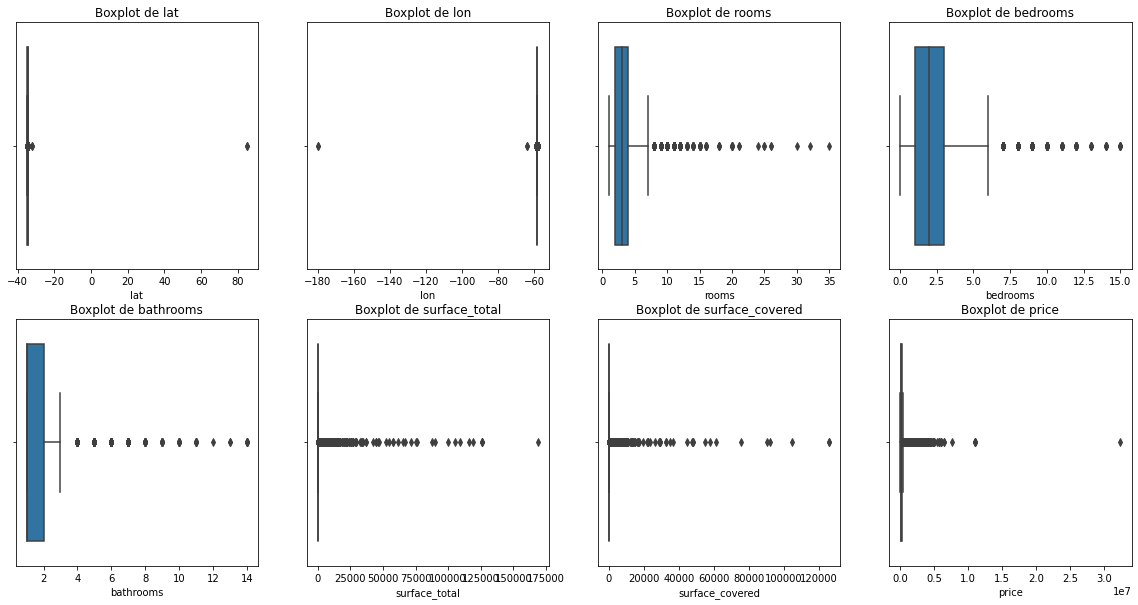

In [15]:
plt.figure(figsize = (20,10))
for i, columna in enumerate(nuemerical_cols):
  plt.subplot(2,4,i+1)
  sns.boxplot(x=data[columna])
  plt.title('Boxplot de ' + str(columna))
plt.show()

-El criterio de las **tres sigmas**. Elige los umbrales mínimo y máximo de la siguiente manera:

mínimo = valor medio - 3 x SD

máximo = valor medio + 3 x SD

Es decir, el umbral mínimo es el valor tres sigmas por debajo del valor medio y el umbral máximo el valor tres sigmas por encima del valor medio.

-El criterio del **rango intercuartílico** elige los umbrales mínimo y máximo de esta otra:

mínimo = Q1 - 1.5 x IQR

máximo = Q3 + 1.5 x IQR

Q1 es el primer cuartil, Q3 es el tercer cuartil e IQR es Q3 - Q1, el rango intercuartílico.


*Cuando la distribución esta sesgada usamos IQR, si es normal usamos 3 sigmas.*




In [16]:
# Método 3 sigmas - estudiamos intervalos
dictio_3s = {}
for columna in nuemerical_cols:
  #tres sigmas
  #print(str(columna))
  columna_mean = data[columna].mean()
  columna_sdt = data[columna].std() 
  
  min_3s = columna_mean  - 3*columna_sdt
  max_3s = columna_mean  + 3*columna_sdt
  dictio_3s[columna] = [min_3s,max_3s]
  #print('(' + str(min_3s) + ',' + str(max_3s) + ')')
  mascara_outliers = np.logical_or(data[columna] < min_3s, data[columna] > max_3s)
    
  print(str(columna) + ':','Perdemos',mascara_outliers.sum(), 'instancias')
print(dictio_3s)  
  

lat: Perdemos 4 instancias
lon: Perdemos 4 instancias
rooms: Perdemos 1376 instancias
bedrooms: Perdemos 1100 instancias
bathrooms: Perdemos 1565 instancias
surface_total: Perdemos 309 instancias
surface_covered: Perdemos 197 instancias
price: Perdemos 2460 instancias
{'lat': [-36.03377373479614, -33.17372612892605], 'lon': [-59.94839914775234, -56.980686819429565], 'rooms': [-1.0914895769670951, 7.291515141154509], 'bedrooms': [-1.3935497115587987, 5.396404379153351], 'bathrooms': [-1.0611251110001063, 4.254699466972003], 'surface_total': [-4162.348446703714, 4529.838504113495], 'surface_covered': [-2667.1765244333283, 2893.0192431342184], 'price': [-620709.6925778633, 1095138.600347956]}


In [17]:
# Método IQR - estudiamos intervalos
dictio_IQR = {}
for columna in nuemerical_cols:
  Q1 = data[columna].quantile(0.25)
  Q3 = data[columna].quantile(0.75)
  IQR = Q3-Q1
  min_IQR = Q1 - 3/2*IQR
  max_IQR = Q3 + 3/2*IQR
  dictio_IQR[columna] = [min_IQR, max_IQR]
  mascara_outliers = np.logical_or(data[columna] < min_IQR, data[columna] > max_IQR)
  print(str(columna) + ':','Perdemos',mascara_outliers.sum(), 'instancias')
print(dictio_IQR)  

lat: Perdemos 26060 instancias
lon: Perdemos 16812 instancias
rooms: Perdemos 1376 instancias
bedrooms: Perdemos 395 instancias
bathrooms: Perdemos 5396 instancias
surface_total: Perdemos 12661 instancias
surface_covered: Perdemos 9866 instancias
price: Perdemos 10503 instancias
{'lat': [-34.70574230000001, -34.495560699999984], 'lon': [-58.64610951604999, -58.26524947325001], 'rooms': [-1.0, 7.0], 'bedrooms': [-2.0, 6.0], 'bathrooms': [-0.5, 3.5], 'surface_total': [-77.0, 267.0], 'surface_covered': [-44.5, 199.5], 'price': [-115571.0, 491285.0]}


In [18]:
# Creamos masacaras y filtramos en cada atributo elegimos el método más conveniente 
mascara_outliers = np.logical_and(
np.logical_not(np.logical_or(data['lat'] < dictio_3s['lat'][0]  , data['lat'] > dictio_3s['lat'][1])),
np.logical_not(np.logical_or(data['lon'] < dictio_3s['lon'][0]  , data['lon'] > dictio_3s['lon'][1])))
print(mascara_outliers.sum())
data = data[mascara_outliers]
print(data.shape)

mascara_outliers1 = np.logical_and(
np.logical_not(np.logical_or(data['rooms'] < dictio_3s['rooms'][0]  , data['rooms'] > dictio_3s['rooms'][1])),
np.logical_not(np.logical_or(data['bedrooms'] < dictio_3s['bedrooms'][0]  , data['bedrooms'] > dictio_3s['bedrooms'][1])))
print(mascara_outliers1.sum())
data = data[mascara_outliers1]
print(data.shape)

mascara_outliers2 = np.logical_and(
np.logical_not(np.logical_or(data['bathrooms'] < dictio_IQR['bathrooms'][0]  , data['bathrooms'] > dictio_IQR['bathrooms'][1])),
np.logical_not(np.logical_or(data['price'] < dictio_3s['price'][0]  , data['price'] > dictio_3s['price'][1])))
print(mascara_outliers2.sum())
data = data[mascara_outliers2]
print(data.shape)

mascara_outliers3 = np.logical_and(
np.logical_not(np.logical_or(data['surface_total'] < dictio_IQR['surface_total'][0]  , data['surface_total'] > dictio_IQR['surface_total'][1])),
np.logical_not(np.logical_or(data['surface_covered'] < dictio_IQR['surface_covered'][0]  , data['surface_covered'] > dictio_IQR['surface_covered'][1])))
print(mascara_outliers3.sum())
data = data[mascara_outliers3]
print(data.shape)


140818
(140818, 19)
138920
(138920, 19)
133282
(133282, 19)
122318
(122318, 19)


In [19]:
140818-122318

18500

Descartamos 18.500 instacias con valores atipicos.

(140818 - 122318 = 18500)

In [20]:
data.describe().round(2)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia
count,114541.00,114512.00,122318.00,122318.00,118522.00,104993.00,104725.00,122318.00,122318.00,122318.00,122318.00,122318.00,122318.00,122318.00,122318.00,122318.00
mean,-34.60,-58.46,2.81,1.79,1.41,83.29,70.17,190840.75,0.02,0.19,0.11,0.07,0.16,0.14,0.22,0.06
std,0.09,0.13,1.06,0.93,0.62,46.69,34.42,126931.54,0.13,0.39,0.31,0.26,0.37,0.35,0.41,0.24
min,-35.12,-59.04,1.00,0.00,1.00,10.00,1.00,6000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-34.62,-58.49,2.00,1.00,1.00,50.00,45.00,108000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,-34.60,-58.44,3.00,2.00,1.00,70.00,60.00,155000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,-34.58,-58.41,3.00,2.00,2.00,103.00,86.00,235000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,-34.21,-57.84,7.00,5.00,3.00,267.00,199.00,1092000.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [21]:
# Filtramos a ojo las siguientes:
# Pedimos bedrooms mayor o igual a 1
data = data[(data.price>=10000) & (data.bedrooms>=1)]

In [22]:
# Filtramos a ojo las siguientes:
# Pedimos superficie cubierta menor o igual a superficie total.
# Pedimos superficie total mayor o igual a 15
data = data[(data.surface_total>=data.surface_covered) & (data.surface_total>=15)]

In [23]:
data.shape

(102724, 19)

## Encoding


Múltiples métodos de Machine Learning y Deep Learning requieren matrices numéricas como datos de entrada, por lo que es necesario transformar variables de tipo categórico para implementarlos.
La manera más sencilla de transformar estos datos es crear variables dummy, proceso también conocido como one-hot encoding.

Tenemos 3 columnas de tipo *object*.
Hacemos dummies para property_type y para l2 (región).
Luego, hacemos clustering y dummies para l3 (barrio).

In [24]:
data = pd.get_dummies(data, columns=['property_type','l2'])

In [25]:
data.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia,property_type_Casa,property_type_Departamento,property_type_PH,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal
1,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,-34.914194,-57.938219,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
5,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1


Hacemos clustering para l3.

In [26]:
#Calculo el valor del m2 para unificar
data['valor_m2_miles'] = (data.price/((data.surface_covered+data.surface_total)/2))/1000
#Creo la nueva variable en que colocaré la media de precio por metro cuadrado que le corresponde al barrio en que se ubica la propiedad
data['valorMedio_M2_Barrio'] = data.groupby(['l3'])['valor_m2_miles'].transform('mean')

In [27]:
data.valorMedio_M2_Barrio.unique()
#obtuvimos las medias (una por cada barrio)

array([2.21324126, 3.49429838, 1.48167558, 2.55585232, 2.01570104,
       2.55269387, 1.82046172, 2.7541621 , 2.51725714, 2.19668198,
       1.57939389, 3.40191331, 2.55043781, 3.45334443, 1.91869565,
       3.40171072, 2.1699859 , 2.69214737, 2.5775914 , 2.46895535,
       2.9167259 , 1.64765281, 2.7801541 , 1.48979878, 2.263033  ,
       3.22698644, 3.86079665, 2.35153989, 2.96667123, 3.02273568,
       2.53552753, 1.44666397, 2.18630202, 1.406129  , 1.85698848,
       2.08111968, 3.01382531, 2.12984735, 1.5377225 , 2.26883247,
       5.82392355, 2.05876802, 2.70327306, 2.04766802, 2.34360342,
       2.16561556, 2.95162498, 2.18640204, 2.26247983, 2.68520875,
       2.24351418, 2.41427478, 1.2973812 , 1.71885201, 1.91941236,
       2.50579984, 1.71963459, 1.24588972, 1.55146655, 1.53587436,
       1.20545499, 1.766487  , 1.73082211, 1.11475291, 0.86222767,
       1.57270279, 1.32400752, 1.16282646, 1.56964306, 1.4053876 ,
       1.01889486, 2.45139656, 1.24433288, 1.24413768, 2.41138

In [28]:
data.columns
#Voy a crear la matriz con que alimento al modelo de agrupamiento


Index(['lat', 'lon', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'jardin', 'cochera', 'parrilla', 'pileta',
       'terraza', 'subte', 'lavadero', 'dependencia', 'property_type_Casa',
       'property_type_Departamento', 'property_type_PH',
       'l2_Bs.As. G.B.A. Zona Norte', 'l2_Bs.As. G.B.A. Zona Oeste',
       'l2_Bs.As. G.B.A. Zona Sur', 'l2_Capital Federal', 'valor_m2_miles',
       'valorMedio_M2_Barrio'],
      dtype='object')

In [29]:
X_valorMedio = data.drop(['lat', 'lon', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'property_type_Casa',
       'property_type_Departamento', 'property_type_PH',
       'l2_Bs.As. G.B.A. Zona Norte', 'l2_Bs.As. G.B.A. Zona Oeste',
       'l2_Bs.As. G.B.A. Zona Sur', 'l2_Capital Federal', 'valor_m2_miles','price', 'parrilla', 'jardin', 'cochera',
       'pileta', 'terraza', 'subte', 'lavadero', 'dependencia'], axis=1)

In [30]:
X_valorMedio_2d = X_valorMedio.values.reshape(-1,1)

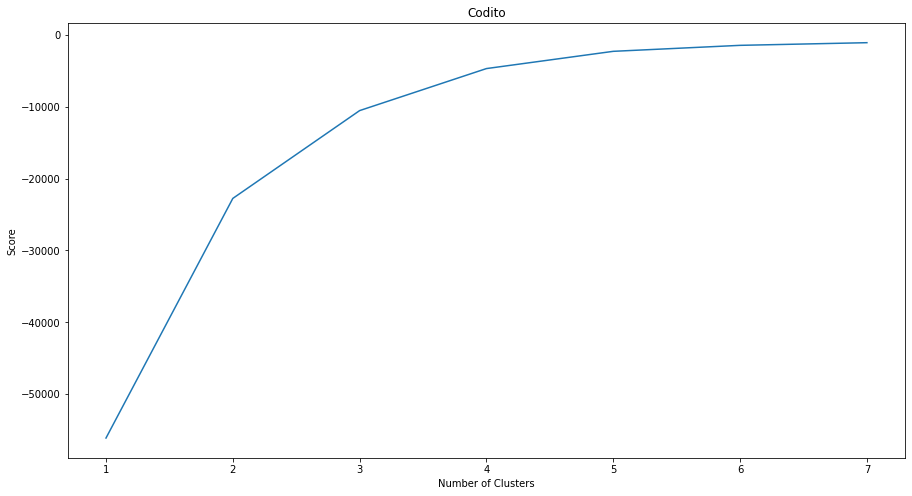

In [31]:
from sklearn.cluster import KMeans
# Graficamos el score para distintos cantidad de cluster's. Seleccionamos el codo de la curva de scores.
Nc = range(1, 8)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X_valorMedio_2d).score(X_valorMedio_2d) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Codito')
plt.show()

In [32]:
from sklearn.cluster import KMeans

# Especificamos el numero adecuado de clusters
# Elegimos n_clusters = 4
kmeans_1 = KMeans(n_clusters=4, random_state=42, n_jobs=-1)

In [33]:
kmeans_1.fit(X_valorMedio_2d)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [34]:
y_kmeans = kmeans_1.predict(X_valorMedio_2d)

centros_1 = kmeans_1.cluster_centers_
print(centros_1)

[[1.62943457]
 [3.35099559]
 [2.5269129 ]
 [5.82392355]]


In [35]:
#Consultamos las etiquetas
etiquetas_1 = kmeans_1.labels_

#Number of clusters in labels, ignoring noise if present.
n_clusters_1 = len(set(etiquetas_1)) - (1 if -1 in etiquetas_1 else 0)
n_noise_1 = list(etiquetas_1).count(-1)

In [36]:
print('Estimated number of clusters: %d' % n_clusters_1)
print('Estimated number of noise points: %d' % n_noise_1)

Estimated number of clusters: 4
Estimated number of noise points: 0


In [37]:
#Inserto nueva columna en data con los valores de clusters del K-Means
data['Kmeans_Barrio']=kmeans_1.labels_
data.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia,property_type_Casa,property_type_Departamento,property_type_PH,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal,valor_m2_miles,valorMedio_M2_Barrio,Kmeans_Barrio
1,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2.484375,2.213241,2
2,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2.777778,3.494298,1
3,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,4.370370,3.494298,1
4,-34.914194,-57.938219,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0.941176,1.481676,0
5,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,2.678571,2.555852,2


In [38]:
# Hacemos dummies al cluster por barrios
data = pd.get_dummies(data, columns = ['Kmeans_Barrio'])

In [39]:
# Tiramos las variables auxiliares creadas
data.drop(columns=['valor_m2_miles', 'valorMedio_M2_Barrio'], inplace=True)
data.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia,property_type_Casa,property_type_Departamento,property_type_PH,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal,Kmeans_Barrio_0,Kmeans_Barrio_1,Kmeans_Barrio_2,Kmeans_Barrio_3
1,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
3,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
4,-34.914194,-57.938219,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0
5,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0


## Imputación de valores faltantes


Los valores faltantes son aquellos que no constan en algunas filas para una o unas variables determinadas. El motivo por el cual se produce esto puede ir desde fallos en los instrumentos de medida hasta sujetos que no asisten a la entrevista o no contestan a determinadas preguntas.

Los 3 motivos principales por los que se suelen tratar los valores perdidos son: pueden introducir un sesgo considerable (una diferencia notable entre los datos observados y los no observados), hacen el análisis y el manejo de los datos más complicado y la pérdida de información que éstos producen.

Imputamos los valores faltantes a continuación. Notar que no representan una gran cantidad en términos del tamaño de nuestro dataset.

In [40]:
data.isna().sum()

lat                            6673
lon                            6673
l3                                0
rooms                             0
bedrooms                          0
bathrooms                      1295
surface_total                     0
surface_covered                   0
price                             0
jardin                            0
cochera                           0
parrilla                          0
pileta                            0
terraza                           0
subte                             0
lavadero                          0
dependencia                       0
property_type_Casa                0
property_type_Departamento        0
property_type_PH                  0
l2_Bs.As. G.B.A. Zona Norte       0
l2_Bs.As. G.B.A. Zona Oeste       0
l2_Bs.As. G.B.A. Zona Sur         0
l2_Capital Federal                0
Kmeans_Barrio_0                   0
Kmeans_Barrio_1                   0
Kmeans_Barrio_2                   0
Kmeans_Barrio_3             

In [41]:
data.shape

(102724, 28)

Baños

In [42]:
#Cantidad de baños de las propiedades
data['bathrooms'].unique()

array([ 2.,  1.,  3., nan])

In [43]:
#Cantidad de faltantes en baños agrupado por cantidad de rooms
data.bathrooms.isnull().groupby([data['rooms']]).sum().astype(int).reset_index(name='count')

,rooms,count
0,1.0,93
1,2.0,454
2,3.0,460
3,4.0,198
4,5.0,82
5,6.0,8
6,7.0,0


Completamos los faltantes en baños en función de la cantidad de rooms (rooms no tiene faltantes). Notar que decidimos imputar con números naturales:

---
Si rooms = 1, entonces bathrooms = 1

Si rooms = 2, entonces bathrooms = 2

Si rooms = 3, entonces bathrooms = 2

Si rooms = 4, entonces bathrooms = 3

Si rooms = 5, entonces bathrooms = 3

Si rooms = 6, entonces bathrooms = 4


In [44]:
data['bathrooms'] = data.apply(
    lambda row: (row['rooms']//2 +1) if np.isnan(row['bathrooms']) else row['bathrooms'],
    axis=1
)

In [45]:
data['bathrooms'].isnull().sum()

0

Superficie total y Superficie Cubierta

Al haber realizado el siguiente drop:

`data = data[(data.surface_total>=data.surface_covered) & (data.surface_total>=15)]`

no quedan valores faltantes en estas columnas. Sin embargo, dejamos la muestra del trabajo realizado previamente a tomar esta decisión. Estas líneas de código no cambian el dataset.

In [46]:
data.surface_total.isnull().groupby([data['bedrooms']]).sum().astype(int).reset_index(name='count')

,bedrooms,count
0,1.0,0
1,2.0,0
2,3.0,0
3,4.0,0
4,5.0,0


In [47]:
data.surface_total.isnull().groupby([data['rooms']]).sum().astype(int).reset_index(name='count')

,rooms,count
0,1.0,0
1,2.0,0
2,3.0,0
3,4.0,0
4,5.0,0
5,6.0,0
6,7.0,0


In [48]:
np.sort(data.groupby(['rooms'])['surface_total'].transform('mean').unique())

array([ 40.35258609,  53.03890327,  87.51439088, 125.48583722,
       158.20164127, 176.95560254, 186.72988506])

In [49]:
data['sup_promedio'] = data.groupby(['rooms'])['surface_total'].transform('mean')

In [50]:
data['surface_total'] = data.apply(
    lambda row: row['sup_promedio'] if np.isnan(row['surface_total']) else row['surface_total'],
    axis=1
)

In [51]:
data.surface_total.isnull().sum()

0

In [52]:
data['sup_cov_promedio'] = data.groupby(['rooms'])['surface_covered'].transform('mean')
print(np.sort(data.sup_cov_promedio.unique()))
data['surface_covered'] = data.apply(
    lambda row: row['sup_cov_promedio'] if np.isnan(row['surface_covered']) else row['surface_covered'],
    axis=1
)

[ 35.69817533  46.00401244  72.24962639 105.0537315  130.68417351
 143.6954023  145.92494715]


In [53]:
data.surface_covered.isnull().sum()

0

In [54]:
data = data.drop(['sup_promedio','sup_cov_promedio'],axis = 1)

In [55]:
data.columns

Index(['lat', 'lon', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'jardin', 'cochera', 'parrilla', 'pileta',
       'terraza', 'subte', 'lavadero', 'dependencia', 'property_type_Casa',
       'property_type_Departamento', 'property_type_PH',
       'l2_Bs.As. G.B.A. Zona Norte', 'l2_Bs.As. G.B.A. Zona Oeste',
       'l2_Bs.As. G.B.A. Zona Sur', 'l2_Capital Federal', 'Kmeans_Barrio_0',
       'Kmeans_Barrio_1', 'Kmeans_Barrio_2', 'Kmeans_Barrio_3'],
      dtype='object')

Latitud y Longitud

In [56]:
data.lat.isnull().groupby([data['l3']]).sum().astype(int)


l3
Abasto                4
Agronomía             0
Almagro             157
Almirante Brown       2
Avellaneda           36
                   ... 
Villa Riachuelo       0
Villa Santa Rita      0
Villa Soldati         0
Villa Urquiza        43
Villa del Parque      1
Name: lat, Length: 89, dtype: int64

In [57]:
#Completamos faltantes en lat y lon usando el promedio de los valores agrupando por barrio respectivamente.
data['lat'].fillna(data.groupby(['l3'])['lat'].transform('mean'), inplace=True)
data['lon'].fillna(data.groupby(['l3'])['lon'].transform('mean'), inplace=True)

Chequeamos que no queden valores faltantes:

In [58]:
data.isnull().sum()

lat                            0
lon                            0
l3                             0
rooms                          0
bedrooms                       0
bathrooms                      0
surface_total                  0
surface_covered                0
price                          0
jardin                         0
cochera                        0
parrilla                       0
pileta                         0
terraza                        0
subte                          0
lavadero                       0
dependencia                    0
property_type_Casa             0
property_type_Departamento     0
property_type_PH               0
l2_Bs.As. G.B.A. Zona Norte    0
l2_Bs.As. G.B.A. Zona Oeste    0
l2_Bs.As. G.B.A. Zona Sur      0
l2_Capital Federal             0
Kmeans_Barrio_0                0
Kmeans_Barrio_1                0
Kmeans_Barrio_2                0
Kmeans_Barrio_3                0
dtype: int64

## Escalado de datos



Salvo por árboles de decisión, los modelos de ML dependen básicamente de variables numéricas. Y estas deben estar en escalas comparables, ya que los modelos no entienden de unidades. Aplicamos MinMaxScaler a las columnas 

['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered'] 

De esta forma obtenemos todas nuestras columnas con valores entre 0 y 1.

In [59]:
from sklearn.preprocessing import MinMaxScaler

In [60]:
scaler = MinMaxScaler()

In [61]:
#Definimos las columnas a escalar
cols_scal = ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

In [62]:
#Aplicamos el scaler a cada columna
for col in cols_scal:
  data[[col]] = scaler.fit_transform(data[[col]])

data.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia,property_type_Casa,property_type_Departamento,property_type_PH,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal,Kmeans_Barrio_0,Kmeans_Barrio_1,Kmeans_Barrio_2,Kmeans_Barrio_3
1,0.569476,0.514406,Boedo,0.166667,0.0,0.333333,0.218254,0.287879,159000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,0.604428,0.501418,Palermo,0.166667,0.0,0.000000,0.119048,0.222222,125000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
3,0.618501,0.493573,Palermo,0.166667,0.0,0.000000,0.277778,0.247475,295000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
4,0.236842,0.915022,La Plata,0.166667,0.0,0.000000,0.138889,0.171717,40000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0
5,0.604187,0.489782,Villa Crespo,0.166667,0.0,0.000000,0.162698,0.277778,150000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0


## Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).


Usamos PCA para obtener una reducción dimensional del dataset. Como ventaja, los modelos corren más ráridamente. Como deventaja su desempeño puede llegar a ser peor. 

In [63]:
from sklearn.decomposition import PCA
pca = PCA(0.95)

In [64]:
data_pca = data.drop(['l3','price'], axis=1)
data_pca = pd.DataFrame(pca.fit_transform(data_pca))
data.reset_index(inplace=True)
data_pca['price'] = np.log(data['price'])
data_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,price
0,-0.132436,-0.638443,0.919774,-0.048252,-0.597639,0.095132,-0.350131,0.214859,-0.550113,0.031124,-0.051276,0.083382,-0.141398,0.062966,11.976659
1,-0.094138,0.713903,0.795745,-0.004903,-0.810700,0.322289,-0.225715,0.461246,-0.601894,0.059999,-0.084065,0.042029,-0.074619,0.134823,11.736069
2,-0.080623,0.716840,0.818321,0.033427,-0.802056,0.315811,-0.256097,0.434176,-0.565818,0.059241,-0.078492,0.042560,-0.063120,0.117979,12.594731
3,1.468332,0.083110,0.890249,-0.461939,-0.539308,-0.219615,0.640455,0.132450,-0.215286,-0.350956,-0.843996,0.074857,-0.252651,0.214769,10.596635
4,-0.085010,-0.671151,1.090739,0.139306,-0.841129,-0.067366,0.479772,0.084589,-0.419371,-0.317696,-0.080736,0.017533,-0.016639,0.173225,11.918391


In [65]:
#Aplicamos logaritmo a nuestra columna target
data = data.drop(['l3', 'index'], axis=1)
data['price'] = np.log(data['price'])
data.head()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia,property_type_Casa,property_type_Departamento,property_type_PH,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal,Kmeans_Barrio_0,Kmeans_Barrio_1,Kmeans_Barrio_2,Kmeans_Barrio_3
0,0.569476,0.514406,0.166667,0.0,0.333333,0.218254,0.287879,11.976659,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,0.604428,0.501418,0.166667,0.0,0.000000,0.119048,0.222222,11.736069,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
2,0.618501,0.493573,0.166667,0.0,0.000000,0.277778,0.247475,12.594731,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
3,0.236842,0.915022,0.166667,0.0,0.000000,0.138889,0.171717,10.596635,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0
4,0.604187,0.489782,0.166667,0.0,0.000000,0.162698,0.277778,11.918391,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0


In [66]:
data.shape

(102724, 27)

Aqui finaliza nuestro trabajo de pre-procesamiento de datos. Terminamos con 2 datasets: data y data_pca. En ambos el target price esta en escala logaritmica. En data_pca aplicamos reducción dimensional para acortar tiempos de maquina. Previamente al análisis de modelos de ML, mostramos la distribución de nuestra variable target:

Text(0.5, 1.0, 'Distribución de target: precio en escala logarítmica')

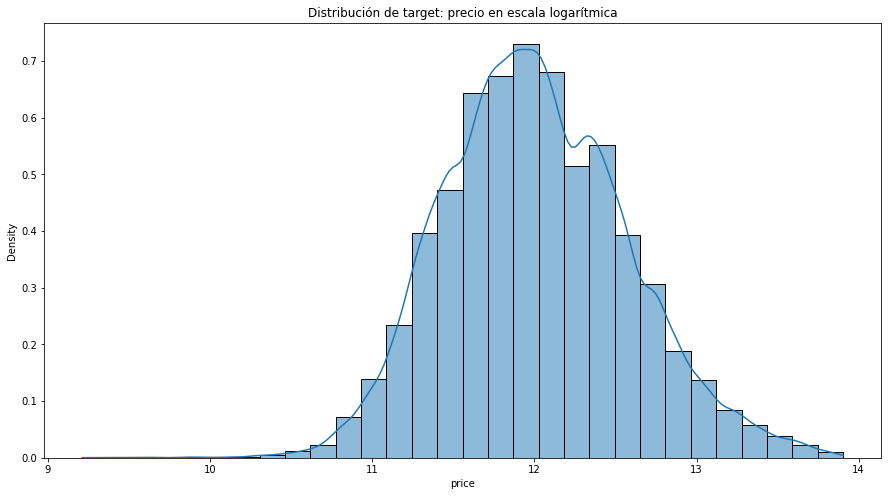

In [67]:
sns.histplot((data.price), bins = 30, kde= True, stat="density")
plt.title('Distribución de target: precio en escala logarítmica')

## Probamos modelos del proyecto anterior

En la siguiente sección aplicamos tres modelos del primer proyecto. No optimizamos sus hiperparámetros. Utilizamos los mismos modelos en los nuevos dataset preprocesados previamente. Mostramos sus desempeños en train y en test con las métricas RECM, MAE y R2. Hacemos gráficos comparativos y asimismo comparamos con el desempeño del proyecto 1.

### Regresión lineal

In [68]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [69]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['price'], axis = 1), data.price, test_size=0.33, random_state=42)

# Crear linear regression 
regr_lineal = linear_model.LinearRegression(normalize = True)

# Train the model 
regr_lineal.fit(X_train, y_train);

Creamos una función auxiliar para evaluar modelos. Imprime en pantalla los errores RECM, MAE y R2 para train y test. Muestra tres gráficos:
1. Residuos contra Predicciones (con logaritmo).
2. Histograma de errores en train y en test.
3. Precio en test contra precio predicho.

Además entrega un diccionario con los errores almacenados.

In [70]:
def evaluar_regresion(model, X_train, X_test, y_train, y_test):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred)))
    rmse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred)))
    mae_train = mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))
    mae_test = mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))
    r2_train = r2_score(np.exp(y_train), np.exp(y_train_pred))
    r2_test = r2_score(np.exp(y_test), np.exp(y_test_pred))
    print(str(model).upper())
    print("ERROR  TRAIN     TEST    ")
    print("------ --------  --------")
    print("%-6s %-9.2f %.2f "%('RECM:',rmse_train,rmse_test))
    print("%-6s %-9.2f %.2f "%('MAE:',mae_train,mae_test))
    print("%-10s %-9.2f %.2f "%('R2:',r2_train,r2_test))
    

    expy_train = np.exp(y_train)
    expy_train_pred = np.exp(y_train_pred)
    expy_test = np.exp(y_test)
    expy_test_pred = np.exp(y_test_pred)
    
    ### GRAFICAMOS LOS RESULTADOS
    plt.figure(figsize = (18,6))
    plt.subplot(1,3,1)
    residuos = y_test - y_test_pred
    
    plt.scatter(y_test_pred, residuos)
    plt.plot(y_test_pred,np.zeros(len(y_test_pred)),c='r')
    plt.xlabel('Predicciones (con log)')
    plt.ylabel('Residuos')
    

    plt.subplot(1,3,2)
    sns.histplot((expy_train - expy_train_pred), bins = 20, label = 'train', color='C2', kde= True, stat="density")
    sns.histplot((expy_test - expy_test_pred), bins = 20, label = 'test', color='C3', kde = True, stat="density")
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,3,3)
    ax.scatter(expy_test,expy_test_pred, s =2,c='C5')

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show();
    return {'RECM':[rmse_train,rmse_test], 'MAE':[mae_train,mae_test], 'R2':[r2_train,r2_test]}

LINEARREGRESSION(COPY_X=TRUE, FIT_INTERCEPT=TRUE, N_JOBS=NONE, NORMALIZE=TRUE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  65468.85  64907.26 
MAE:   41342.22  41105.97 
R2:        0.74      0.74 


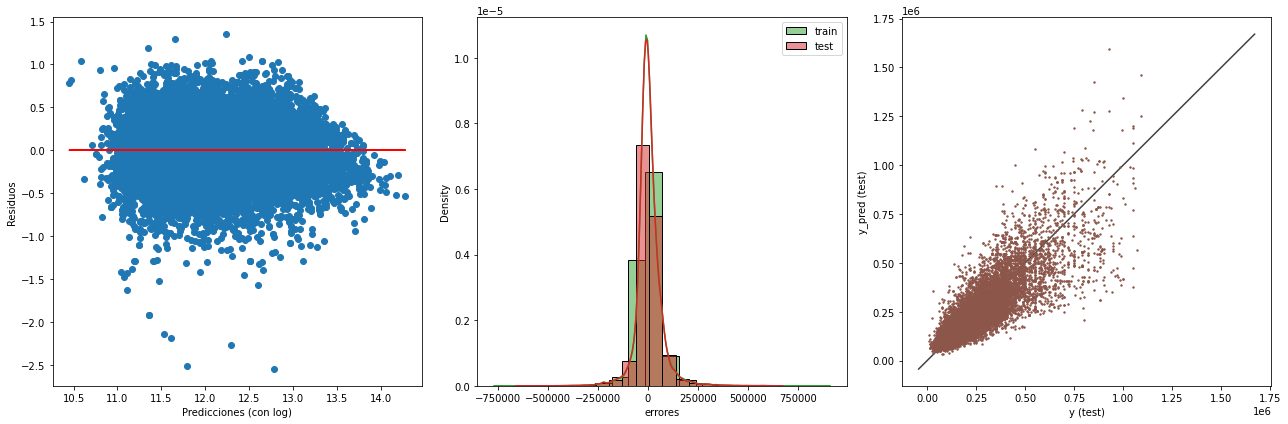

In [71]:
errores_regr = evaluar_regresion(regr_lineal, X_train, X_test, y_train, y_test)

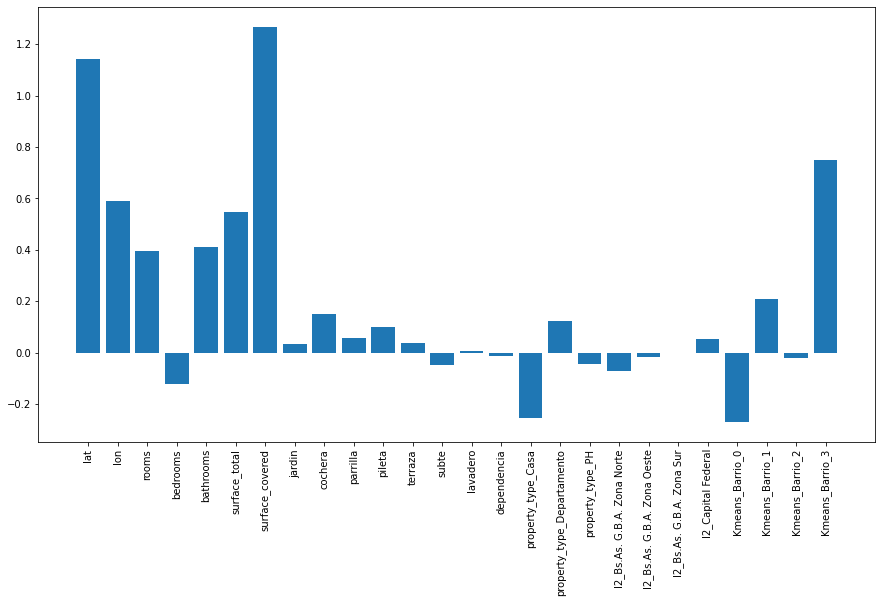

In [72]:
plt.bar(np.arange(26), regr_lineal.coef_)
plt.xticks(np.arange(26), [str(name) for name in data.columns if name !='price'], rotation = 'vertical')
plt.show()

In [73]:
regr_lineal.coef_

array([ 1.14112104e+00,  5.90514718e-01,  3.94885874e-01, -1.23142674e-01,
        4.12202236e-01,  5.47149353e-01,  1.26771906e+00,  3.33162508e-02,
        1.51535420e-01,  5.78663631e-02,  9.85000336e-02,  3.80851737e-02,
       -4.86060105e-02,  6.06694262e-03, -1.24806206e-02, -2.54460264e-01,
        1.23143947e-01, -4.42313523e-02, -7.26314761e-02, -1.90290875e-02,
       -8.51316411e-04,  5.27027768e-02, -2.70849274e-01,  2.06620062e-01,
       -1.94071486e-02,  7.48397745e-01])

Podemos observar que las variables más relevantes para el modelo de Regresión lineal son 'lat' y 'surface_covered'.

### 2-Vecinos más cercanos

Evaluar la regresión de 2-vecinos más cercanos en el dataset sin aplicar pca demora aproximadamente 150 segundos. Se puede evitar correr esta sub-sección. Igualmente dejo los gráficos presentados junto con el código comentado.

In [74]:
#Create model
regr_2v = KNeighborsRegressor(2, n_jobs = -1)
    
#Train model
regr_2v.fit(X_train,y_train);

KNEIGHBORSREGRESSOR(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                    METRIC_PARAMS=NONE, N_JOBS=-1, N_NEIGHBORS=2, P=2,
                    WEIGHTS='UNIFORM')
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  27955.42  52012.51 
MAE:   12751.17  26869.81 
R2:        0.95      0.83 


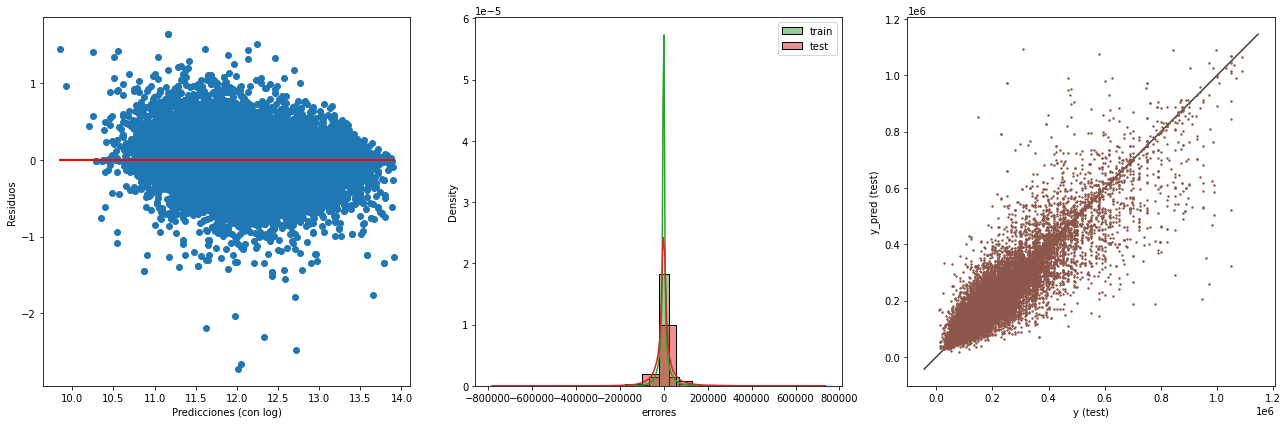

In [75]:
errores_2v = evaluar_regresion(regr_2v, X_train, X_test, y_train, y_test)

### Árbol de desición

In [76]:
#Crear modelo
clf_arbol = DecisionTreeRegressor(max_depth = 19, random_state = 42)

# Entrenar el modelo
clf_arbol.fit(X_train,y_train);

DECISIONTREEREGRESSOR(CCP_ALPHA=0.0, CRITERION='MSE', MAX_DEPTH=19,
                      MAX_FEATURES=NONE, MAX_LEAF_NODES=NONE,
                      MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                      MIN_SAMPLES_LEAF=1, MIN_SAMPLES_SPLIT=2,
                      MIN_WEIGHT_FRACTION_LEAF=0.0, PRESORT='DEPRECATED',
                      RANDOM_STATE=42, SPLITTER='BEST')
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  21180.00  50645.58 
MAE:   8926.40   25262.57 
R2:        0.97      0.84 


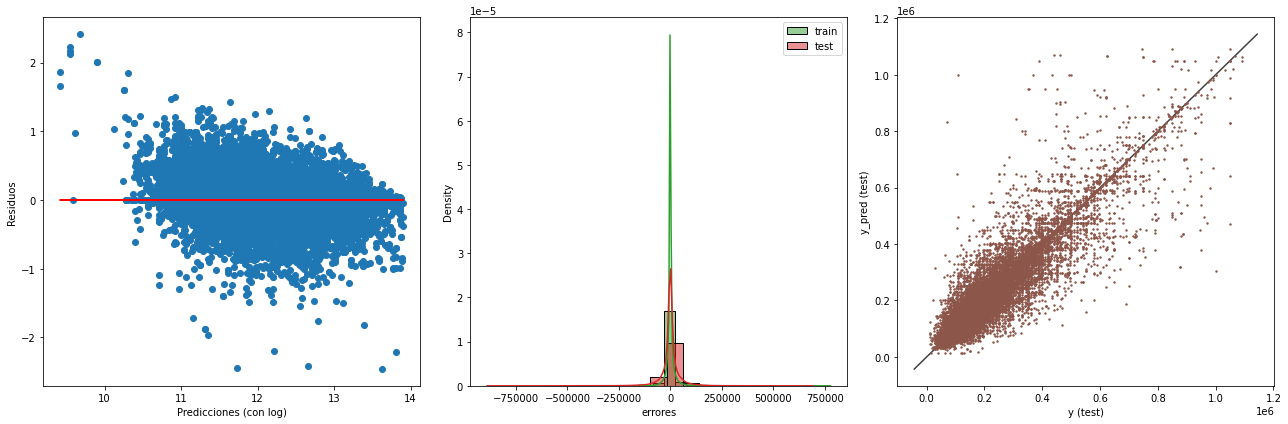

In [77]:
errores_arbol = evaluar_regresion(clf_arbol, X_train, X_test, y_train, y_test)

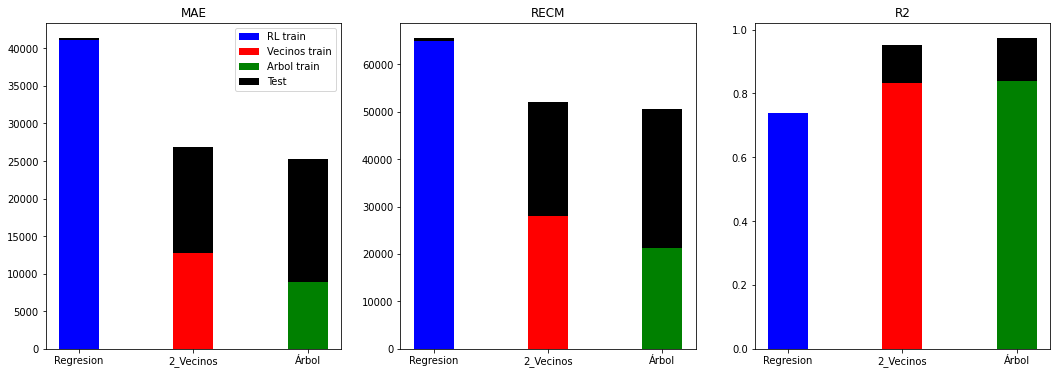

In [78]:
mae = [errores_regr['MAE'][1],errores_2v['MAE'][1],errores_arbol['MAE'][1]]
recm = [errores_regr['RECM'][1],errores_2v['RECM'][1],errores_arbol['RECM'][1]]
r2 = [errores_regr['R2'][1],errores_2v['R2'][1],errores_arbol['R2'][1]]
mae_train = [errores_regr['MAE'][0]-errores_regr['MAE'][1], errores_2v['MAE'][0]-errores_2v['MAE'][1], errores_arbol['MAE'][0]-errores_arbol['MAE'][1]]
recm_train = [errores_regr['RECM'][0]-errores_regr['RECM'][1], errores_2v['RECM'][0]-errores_2v['RECM'][1], errores_arbol['RECM'][0]-errores_arbol['RECM'][1]]
r2_train = [errores_regr['R2'][0]-errores_regr['R2'][1], errores_2v['R2'][0]-errores_2v['R2'][1], errores_arbol['R2'][0]-errores_arbol['R2'][1]]
ticks_x =('Regresion', '2_Vecinos', 'Árbol')
color = ('b','r','g')
width = 0.35
x=np.arange(3)   
### GRAFICAMOS LOS RESULTADOS
plt.figure(figsize = (18,6))
plt.subplot(1,3,1)
p =plt.bar(x,mae,color=color,width=width)
p2 = plt.bar(x,mae_train,width=width,bottom=mae,color='k')
plt.legend((p[0],p[1],p[2],p2[0]), ('RL train','Vecinos train', 'Arbol train','Test'))
plt.title('MAE')
plt.xticks(x,ticks_x)
plt.subplot(1,3,2)
plt.bar(x,recm,color=color,width=width)
plt.bar(x,recm_train,width=width,bottom=recm,color='k')
plt.title('RECM')
plt.xticks(x,ticks_x)
plt.subplot(1,3,3)
plt.bar(x,r2,width=width,color=color)
plt.bar(x,r2_train,width=width,bottom=r2,color='k')
plt.title('R2')
plt.xticks(x,ticks_x)
plt.show()

En términos de sesgo el mejor modelo es el Árbol de desición pero el modelo de Regresión lineal tiene menos varianza.

In [79]:
print('El precio promedio de las propiedades del dataset es: US$%.2f'%(np.exp(data.price).mean()))

El precio promedio de las propiedades del dataset es: US$194732.57


In [80]:
l1=[errores_regr[key][0].round(2) for key in errores_regr.keys()]
l2=[errores_2v[key][0].round(2) for key in errores_2v.keys()]
l3=[errores_arbol[key][0].round(2) for key in errores_arbol.keys()]
names=['Regresión', '2-vecinos', 'Árbol']
df_errores_train = pd.DataFrame(np.array([l1,l2,l3]), columns=['RECM','MAE','R2'])
df_errores_train.insert(0,'Regresor',names,True)
print('Errores en train')
print(df_errores_train)
l1=[errores_regr[key][1].round(2) for key in errores_regr.keys()]
l2=[errores_2v[key][1].round(2) for key in errores_2v.keys()]
l3=[errores_arbol[key][1].round(2) for key in errores_arbol.keys()]
names=['Regresión', '2-vecinos', 'Árbol']
df_errores_test = pd.DataFrame(np.array([l1,l2,l3]), columns=['RECM','MAE','R2'])
df_errores_test.insert(0,'Regresor',names,True)
print('Errores en test')
print(df_errores_test)

Errores en train
    Regresor      RECM       MAE    R2
0  Regresión  65468.85  41342.22  0.74
1  2-vecinos  27955.42  12751.17  0.95
2      Árbol  21180.00   8926.40  0.97
Errores en test
    Regresor      RECM       MAE    R2
0  Regresión  64907.26  41105.97  0.74
1  2-vecinos  52012.51  26869.81  0.83
2      Árbol  50645.58  25262.57  0.84


Podemos observar que el modelo de árbol de decisión tiene el mejor desempeño en test en las tres métricas estudiadas. Además mejora ampliamente los desempeños del proyecto 1. 

Recordemos que en el primer proyecto nuestro mejor modelo obtuvo un desempeño de US\$135073 para RECM en test. En este caso, el error RECM en test para el modelo de árbol de decisión es de US\$50645.58. 

Observamos además que el error MAE en test para el modelo de árbol desciende a US\$25262.57. Estamos hablando de un error de predicción promedio de alrededor del 13% (el precio promedio de las propiedades de nuestro dataset es de US\$194732). Sin embargo, la diferencia entre el desempeño en train y en test es considerablemente alta por que lo que podemos decir que estamos en una situación de overfitting que intentaremos mejorar en la próxima sección. 

Estas mejoras se deben al trabajo de preprocesamiento que realizamos previamente en la parte A. Sumado a las nuevas variables que agregamos a nuestro dataset. Cada uno de los puntos realizados previamente contribuye significativamente a las mejoras en la medición de errores con nuestras métricas.

A continuación realizamos el mismo trabajo en el dataset con reducción dimensional.

Text(0, 0.5, 'MAE')

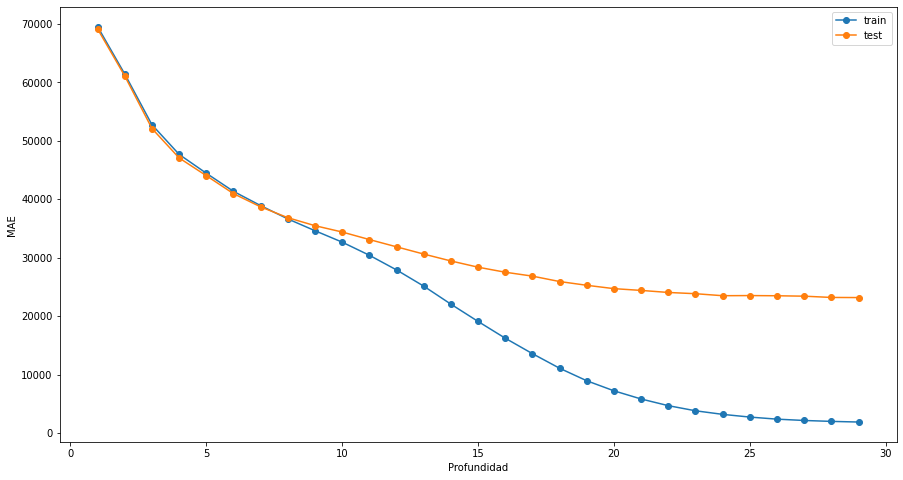

In [81]:
#Optimización de 1 hiperparámetro para el árbol de decisión
profundidad = range(1, 30)
# Definimos las listas vacias para los valores de accuracy deseados
lista_recm_train_a = []
lista_recm_test_a = []
# Generamos en loop sobre los distintos valores de k 
for p in profundidad:
    
    # Vamos a repetir el siguiente bloque de código
    
    # Definir el modelo con el valor de vecinos deseado
    clf = DecisionTreeRegressor(max_depth = p, random_state = 42)
    
    # Entrenar el modelo
    clf.fit(X_train,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    train_recm = mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    test_recm = mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))
    
    # Agregar la información a las listas
    lista_recm_train_a.append(train_recm)
    lista_recm_test_a.append(test_recm)

plt.plot(profundidad, lista_recm_train_a,'o-', label='train')
plt.plot(profundidad, lista_recm_test_a, 'o-', label='test' )
plt.legend()
plt.xlabel('Profundidad')
plt.ylabel('MAE')

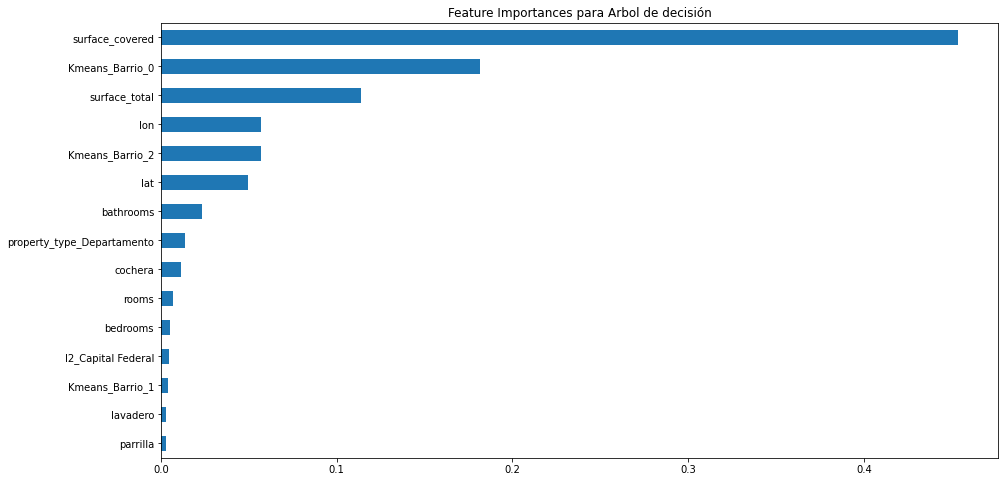

In [82]:
feat_importances = pd.Series(clf_arbol.feature_importances_, index=[str(col) for col in data.columns if col!='price'])
feat_importances.nlargest(15).plot(kind='barh').invert_yaxis()
plt.title('Feature Importances para Arbol de decisión')
plt.show()

### PCA


Probamos los mismos modelos con el dataset PCA con reducción dimensional. 

In [83]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca.drop(['price'], axis = 1), data_pca.price, test_size=0.33, random_state=42)

regr_lineal_pca = linear_model.LinearRegression()

# Train the model 
regr_lineal_pca.fit(X_train_pca, y_train_pca);

LINEARREGRESSION(COPY_X=TRUE, FIT_INTERCEPT=TRUE, N_JOBS=NONE, NORMALIZE=FALSE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  78477.35  76758.18 
MAE:   47383.26  46739.23 
R2:        0.63      0.63 


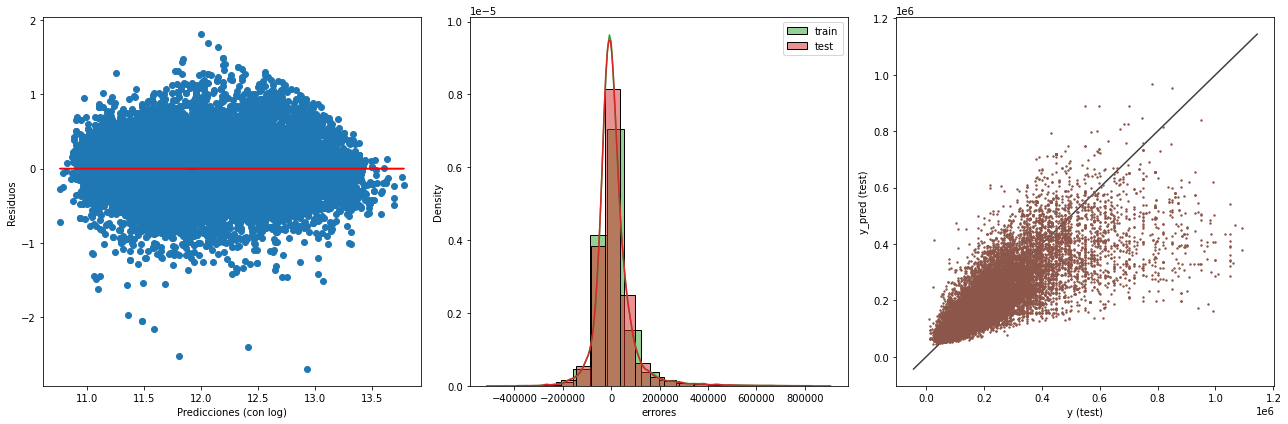

In [84]:
errores_regr_pca = evaluar_regresion(regr_lineal_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

In [85]:
clf_2v_pca = KNeighborsRegressor(2)
    
# Entrenar el modelo
clf_2v_pca.fit(X_train_pca, y_train_pca)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

KNEIGHBORSREGRESSOR(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                    METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=2, P=2,
                    WEIGHTS='UNIFORM')
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  29071.27  54355.45 
MAE:   13245.08  28095.22 
R2:        0.95      0.82 


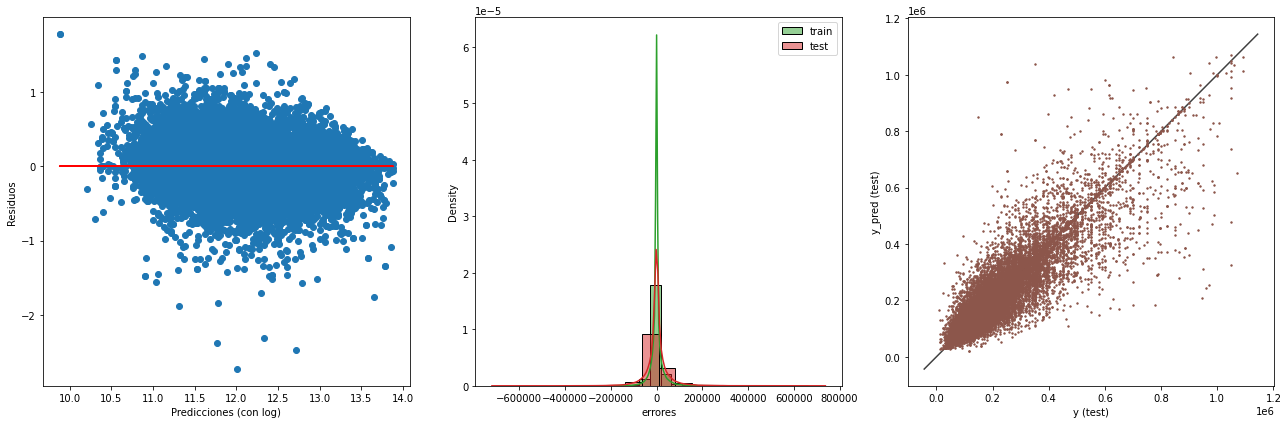

In [86]:
errores_2v_pca = evaluar_regresion(clf_2v_pca,X_train_pca, X_test_pca, y_train_pca, y_test_pca)

In [87]:
clf_arbol_pca = DecisionTreeRegressor(max_depth = 10)
# Entrenar el modelo
clf_arbol_pca.fit(X_train_pca, y_train_pca)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DECISIONTREEREGRESSOR(CCP_ALPHA=0.0, CRITERION='MSE', MAX_DEPTH=10,
                      MAX_FEATURES=NONE, MAX_LEAF_NODES=NONE,
                      MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                      MIN_SAMPLES_LEAF=1, MIN_SAMPLES_SPLIT=2,
                      MIN_WEIGHT_FRACTION_LEAF=0.0, PRESORT='DEPRECATED',
                      RANDOM_STATE=NONE, SPLITTER='BEST')
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  61515.47  65453.99 
MAE:   37411.58  39526.27 
R2:        0.77      0.73 


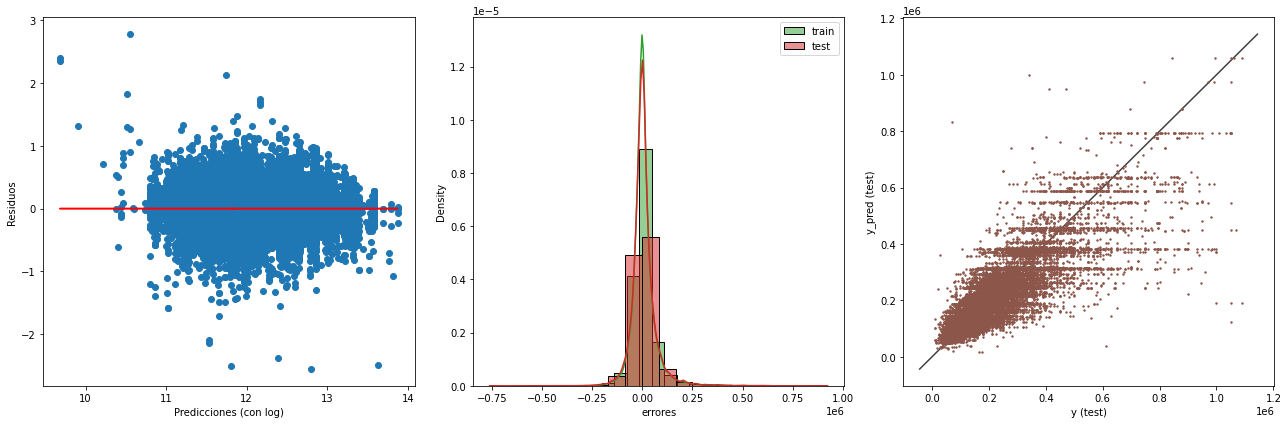

In [88]:
errores_arbol_pca = evaluar_regresion(clf_arbol_pca,X_train_pca, X_test_pca, y_train_pca, y_test_pca)

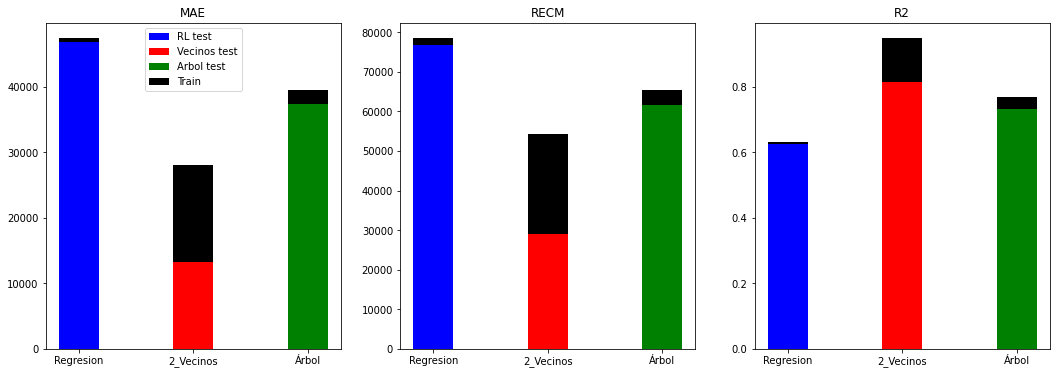

In [89]:
mae_pca = [errores_regr_pca['MAE'][1],errores_2v_pca['MAE'][1],errores_arbol_pca['MAE'][1]]
recm_pca = [errores_regr_pca['RECM'][1],errores_2v_pca['RECM'][1],errores_arbol_pca['RECM'][1]]
r2_pca = [errores_regr_pca['R2'][1],errores_2v_pca['R2'][1],errores_arbol_pca['R2'][1]]
mae_pca_train = [errores_regr_pca['MAE'][0]-errores_regr_pca['MAE'][1], errores_2v_pca['MAE'][0]-errores_2v_pca['MAE'][1], errores_arbol_pca['MAE'][0]-errores_arbol_pca['MAE'][1]]
recm_pca_train = [errores_regr_pca['RECM'][0]-errores_regr_pca['RECM'][1], errores_2v_pca['RECM'][0]-errores_2v_pca['RECM'][1], errores_arbol_pca['RECM'][0]-errores_arbol_pca['RECM'][1]]
r2_pca_train = [errores_regr_pca['R2'][0]-errores_regr_pca['R2'][1], errores_2v_pca['R2'][0]-errores_2v_pca['R2'][1], errores_arbol_pca['R2'][0]-errores_arbol_pca['R2'][1]]
ticks_x =('Regresion', '2_Vecinos', 'Árbol')
color = ('b','r','g')
width = 0.35   
### GRAFICAMOS LOS RESULTADOS
plt.figure(figsize = (18,6))
plt.subplot(1,3,1)
p =plt.bar(x,mae_pca,color=color,width=width)
p2 = plt.bar(x,mae_pca_train,width=width,bottom=mae_pca,color='k')
plt.legend((p[0],p[1],p[2],p2[0]), ('RL test','Vecinos test', 'Arbol test','Train'))
plt.title('MAE')
plt.xticks(x,ticks_x)
plt.subplot(1,3,2)
plt.bar(x,recm_pca,color=color,width=width)
plt.bar(x,recm_pca_train,width=width,bottom=recm_pca,color='k')
plt.title('RECM')
plt.xticks(x,ticks_x)
plt.subplot(1,3,3)
plt.bar(x,r2_pca,width=width,color=color)
plt.bar(x,r2_pca_train,width=width,bottom=r2_pca,color='k')
plt.title('R2')
plt.xticks(x,ticks_x)
plt.show()

2-vecinos más cercanos tiene mejor performance en test para el dataset con reducción dimansional en las tres métrcias analizadas. Todas las veces que evaluamos regresiones en el primero de los gráficos observamos que aún queda estructura en los residuos con logaritmo, no se observa ruido real. En las puntas (propiedades de valor bajo o alto) los gráficos aparentan 'redondeados'. Las distribuciones en train y en test de los errores son similares, aunque los errores en train son más concentrados entorno al cero. En el tercero de los gráficos podemos observar que nuestros modelos tienen alta dispersión para precios altos. Una estrategia en un futuro podria ser truncar el dataset a propiedades cuyos precios reales no superen por ejemplo US\$600.000 o US\$800.000.

# PARTE B - Modelos Avanzados



1. Elige dos de los modelos avanzados vistos Compara con el desempeño obtenido en el proyecto 01 (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.
2. Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.
3. Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

## Regresión lineal con atributos polinómicos y regularización


Hacemos regresión lineal con atributos polinómicos. Aplicamos regularización de tipo Lasso y validación cruzada con 5 particiones. Usamos nuesto dataset con reducción dimensional para mejorar los tiempos.

In [90]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
Xpoly =  data_pca.drop(['price'],axis = 1)
ypoly =  data_pca.price

poly2 = PolynomialFeatures(degree = 2)
X2poly = poly2.fit_transform(Xpoly)

X2poly_train, X2poly_test, y2poly_train, y2poly_test = train_test_split(X2poly, ypoly, test_size=0.25, random_state=42)

reg_lasso = Lasso(alpha = 0.001)
print('Scores en train para cross-validation:')
scores = cross_val_score(reg_lasso, X2poly_train, y2poly_train, cv=5, scoring='r2', n_jobs = -1)
scores


Scores en train para cross-validation:


array([0.73083888, 0.71469962, 0.72687005, 0.72498991, 0.72856708])

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 1
Agregamos atributos hasta la potencia 1
Scores en train para cross-validation:
[0.69630084 0.68080848 0.69145178 0.69123988 0.69435315]
LASSO(ALPHA=0.001, COPY_X=TRUE, FIT_INTERCEPT=TRUE, MAX_ITER=1000,
      NORMALIZE=FALSE, POSITIVE=FALSE, PRECOMPUTE=FALSE, RANDOM_STATE=NONE,
      SELECTION='CYCLIC', TOL=0.0001, WARM_START=FALSE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  78278.31  77571.67 
MAE:   47196.27  46840.33 
R2:        0.63      0.63 


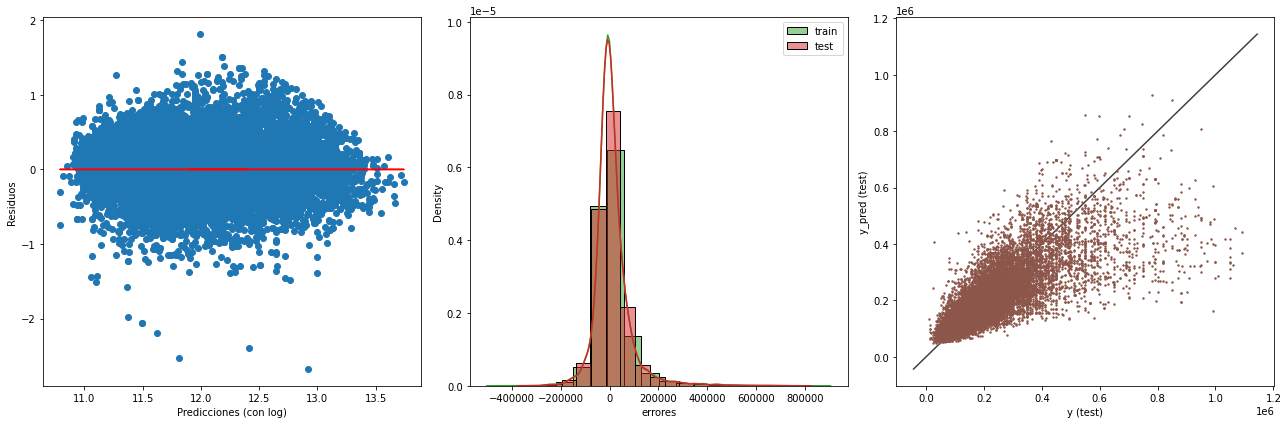

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 2
Agregamos atributos hasta la potencia 2
Scores en train para cross-validation:
[0.73083888 0.71469962 0.72687005 0.72498991 0.72856708]
LASSO(ALPHA=0.001, COPY_X=TRUE, FIT_INTERCEPT=TRUE, MAX_ITER=1000,
      NORMALIZE=FALSE, POSITIVE=FALSE, PRECOMPUTE=FALSE, RANDOM_STATE=NONE,
      SELECTION='CYCLIC', TOL=0.0001, WARM_START=FALSE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  74133.93  73397.38 
MAE:   44538.11  44074.83 
R2:        0.66      0.67 


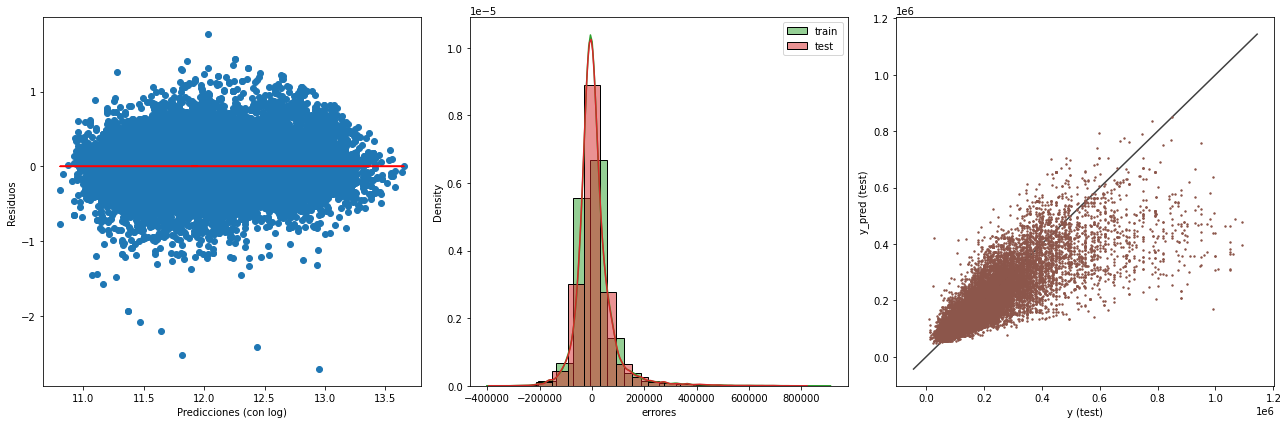

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 3
Agregamos atributos hasta la potencia 3
Scores en train para cross-validation:


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[0.73151785 0.71533838 0.72743998 0.72575261 0.72887151]
LASSO(ALPHA=0.001, COPY_X=TRUE, FIT_INTERCEPT=TRUE, MAX_ITER=1000,
      NORMALIZE=FALSE, POSITIVE=FALSE, PRECOMPUTE=FALSE, RANDOM_STATE=NONE,
      SELECTION='CYCLIC', TOL=0.0001, WARM_START=FALSE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  73888.04  73083.71 
MAE:   44514.65  44018.02 
R2:        0.67      0.67 


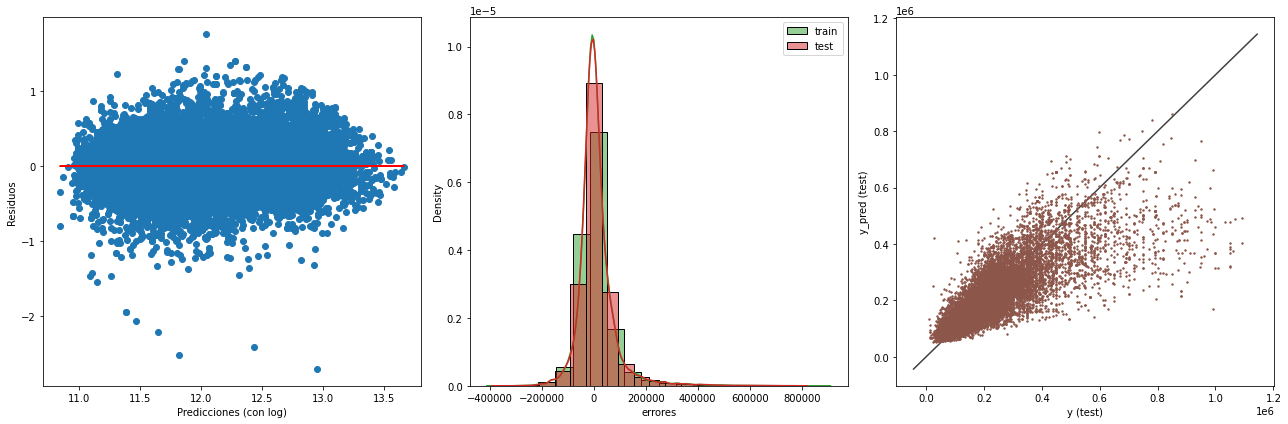

In [91]:
for idx,potencia in enumerate(range(1,4)):
    print(f'REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO {idx + 1}')
    print(f'Agregamos atributos hasta la potencia {potencia}')
    
    polyk = PolynomialFeatures(degree = potencia)
    Xkpoly = polyk.fit_transform(Xpoly)
    
    X_polyk_train, X_polyk_test, y_polyk_train, y_polyk_test = train_test_split(
        Xkpoly, ypoly, test_size=0.25, random_state=42)
    print('Scores en train para cross-validation:')
    scores = cross_val_score(reg_lasso, X_polyk_train, y_polyk_train, cv=5, scoring='r2', n_jobs = -1)
    print(scores)
    reg_lasso.fit(X_polyk_train, y_polyk_train)
    
    evaluar_regresion(reg_lasso, X_polyk_train, X_polyk_test, y_polyk_train, y_polyk_test)
    

Podemos observar una mejora de grado 1 a grado 2 y luego a partir de grado 2 los errores se matienen constantes a medida que crece el grado. Por lo tanto, continuamos trabajando con grado 2.

In [92]:
#Predecimos en los datos de test
reg_lasso.fit(X2poly_train,y2poly_train)
#predictionpoly = reg_lasso.predict(X2poly_test)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

LASSO(ALPHA=0.001, COPY_X=TRUE, FIT_INTERCEPT=TRUE, MAX_ITER=1000,
      NORMALIZE=FALSE, POSITIVE=FALSE, PRECOMPUTE=FALSE, RANDOM_STATE=NONE,
      SELECTION='CYCLIC', TOL=0.0001, WARM_START=FALSE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  74133.93  73397.38 
MAE:   44538.11  44074.83 
R2:        0.66      0.67 


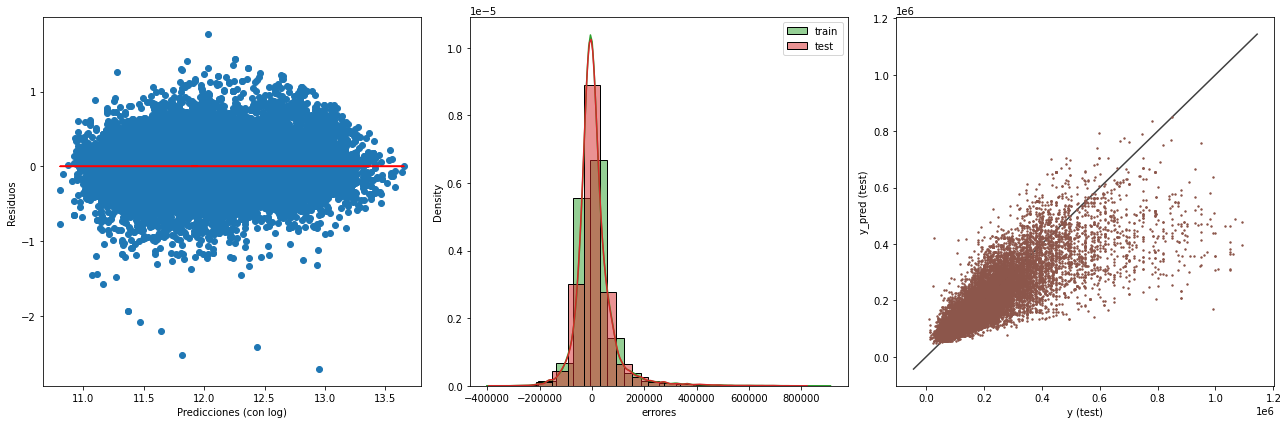

In [93]:
reg_lasso.fit(X2poly_train,y2poly_train)
errores_lasso = evaluar_regresion(reg_lasso, X2poly_train, X2poly_test, y2poly_train, y2poly_test)

Mejoramos el desempeño con grid search:

In [94]:
import scipy as sp
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


Optimización de hiperparámetros con Grid Search:

Objetivo a minimizar en modelo Lasso, 
$$
\left(\frac{1} {2 * n-samples}\right) * ||y - X_w||^2_2 + \alpha * ||w||_1
$$
1. alpha $(\alpha$ -float$)$: Constante que multiplica el término $L_1$. Debe ser mayor o igual a cero. Valor de $\alpha = 0$ significa modelo de Regresión lineal. Por default se setea en 1. Cuanto más grande sea $\alpha$ los coeficientes deberan ser más cercanos a cero. Seleccionamos en la grilla alpha:[0.00001,0.0001].

2. tol (float, default=1e-4): tolerancia para la optimización. Seleccionamos en la grilla tol:[0.2,0.1].

3. max_iter (int, default=1000): El número máximo de iteraciones. Seleccionamos en la grilla max_iter':[1000,2000,5000].

In [95]:
# Grilla para Grid Search
param_grid = {'alpha':[0.00001,0.0001], 'tol':[0.2,0.1], 'max_iter':[1000,2000,5000]}


In [96]:
#ESTRATEGIA: Grid Search
reg_lasso_gs = Lasso()
model_lasso_gs = GridSearchCV(reg_lasso_gs, param_grid=param_grid, cv=5, scoring='r2', n_jobs = -1)

# Entrenamos:
model_lasso_gs.fit(X2poly_train, y2poly_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001],
                         'max_iter': [1000, 2000, 5000], 'tol': [0.2, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [97]:
print("Mejores parametros: "+str(model_lasso_gs.best_params_))
print("Mejor Score: %.4f"%(model_lasso_gs.best_score_) + '\n')

scores = pd.DataFrame(model_lasso_gs.cv_results_)
scores

Mejores parametros: {'alpha': 1e-05, 'max_iter': 2000, 'tol': 0.1}
Mejor Score: 0.7820



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.244852,0.017363,0.007517,0.000350,1e-05,1000,0.2,"{'alpha': 1e-05, 'max_iter': 1000, 'tol': 0.2}",0.732956,0.716669,0.728468,0.727286,0.728459,0.726768,0.005409,7
1,38.155143,4.933763,0.007654,0.000281,1e-05,1000,0.1,"{'alpha': 1e-05, 'max_iter': 1000, 'tol': 0.1}",0.785692,0.769799,0.786820,0.782153,0.785033,0.781899,0.006243,3
2,0.253082,0.005051,0.007599,0.000315,1e-05,2000,0.2,"{'alpha': 1e-05, 'max_iter': 2000, 'tol': 0.2}",0.732956,0.716669,0.728468,0.727286,0.728459,0.726768,0.005409,7
3,39.013874,5.777880,0.007755,0.000342,1e-05,2000,0.1,"{'alpha': 1e-05, 'max_iter': 2000, 'tol': 0.1}",0.785692,0.769799,0.786820,0.782153,0.785295,0.781952,0.006270,1
4,0.254652,0.007603,0.007653,0.000111,1e-05,5000,0.2,"{'alpha': 1e-05, 'max_iter': 5000, 'tol': 0.2}",0.732956,0.716669,0.728468,0.727286,0.728459,0.726768,0.005409,7
5,38.974456,5.612008,0.009102,0.003116,1e-05,5000,0.1,"{'alpha': 1e-05, 'max_iter': 5000, 'tol': 0.1}",0.785692,0.769799,0.786820,0.782153,0.785295,0.781952,0.006270,1
6,0.254310,0.005618,0.007877,0.000159,0.0001,1000,0.2,"{'alpha': 0.0001, 'max_iter': 1000, 'tol': 0.2}",0.732488,0.716092,0.727884,0.726821,0.728303,0.726318,0.005464,10
7,3.740044,0.083437,0.007572,0.000364,0.0001,1000,0.1,"{'alpha': 0.0001, 'max_iter': 1000, 'tol': 0.1}",0.769418,0.753864,0.768149,0.765110,0.767779,0.764864,0.005676,4
8,0.256184,0.015448,0.007351,0.000481,0.0001,2000,0.2,"{'alpha': 0.0001, 'max_iter': 2000, 'tol': 0.2}",0.732488,0.716092,0.727884,0.726821,0.728303,0.726318,0.005464,10
9,3.725043,0.079290,0.007481,0.000216,0.0001,2000,0.1,"{'alpha': 0.0001, 'max_iter': 2000, 'tol': 0.1}",0.769418,0.753864,0.768149,0.765110,0.767779,0.764864,0.005676,4


GRIDSEARCHCV(CV=5, ERROR_SCORE=NAN,
             ESTIMATOR=LASSO(ALPHA=1.0, COPY_X=TRUE, FIT_INTERCEPT=TRUE,
                             MAX_ITER=1000, NORMALIZE=FALSE, POSITIVE=FALSE,
                             PRECOMPUTE=FALSE, RANDOM_STATE=NONE,
                             SELECTION='CYCLIC', TOL=0.0001, WARM_START=FALSE),
             IID='DEPRECATED', N_JOBS=-1,
             PARAM_GRID={'ALPHA': [1E-05, 0.0001],
                         'MAX_ITER': [1000, 2000, 5000], 'TOL': [0.2, 0.1]},
             PRE_DISPATCH='2*N_JOBS', REFIT=TRUE, RETURN_TRAIN_SCORE=FALSE,
             SCORING='R2', VERBOSE=0)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  61399.74  61126.35 
MAE:   38858.98  38789.30 
R2:        0.77      0.77 


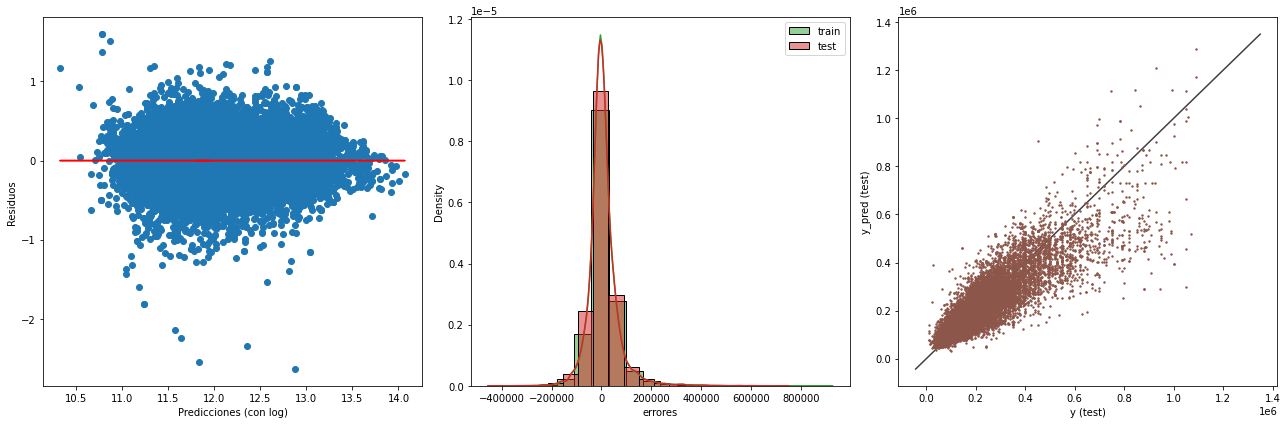

In [98]:

errores_lasso_gs = evaluar_regresion(model_lasso_gs, X2poly_train, X2poly_test, y2poly_train, y2poly_test)

## Random Forest

In [99]:
# Importar modelo 
from sklearn.ensemble import RandomForestRegressor
# Instancio modelo con 100 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
#Entrenar
rf.fit(X_train,y_train);

RANDOMFORESTREGRESSOR(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CRITERION='MSE',
                      MAX_DEPTH=NONE, MAX_FEATURES='AUTO', MAX_LEAF_NODES=NONE,
                      MAX_SAMPLES=NONE, MIN_IMPURITY_DECREASE=0.0,
                      MIN_IMPURITY_SPLIT=NONE, MIN_SAMPLES_LEAF=1,
                      MIN_SAMPLES_SPLIT=2, MIN_WEIGHT_FRACTION_LEAF=0.0,
                      N_ESTIMATORS=100, N_JOBS=NONE, OOB_SCORE=FALSE,
                      RANDOM_STATE=42, VERBOSE=0, WARM_START=FALSE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  16516.67  37333.03 
MAE:   8245.83   19478.91 
R2:        0.98      0.91 


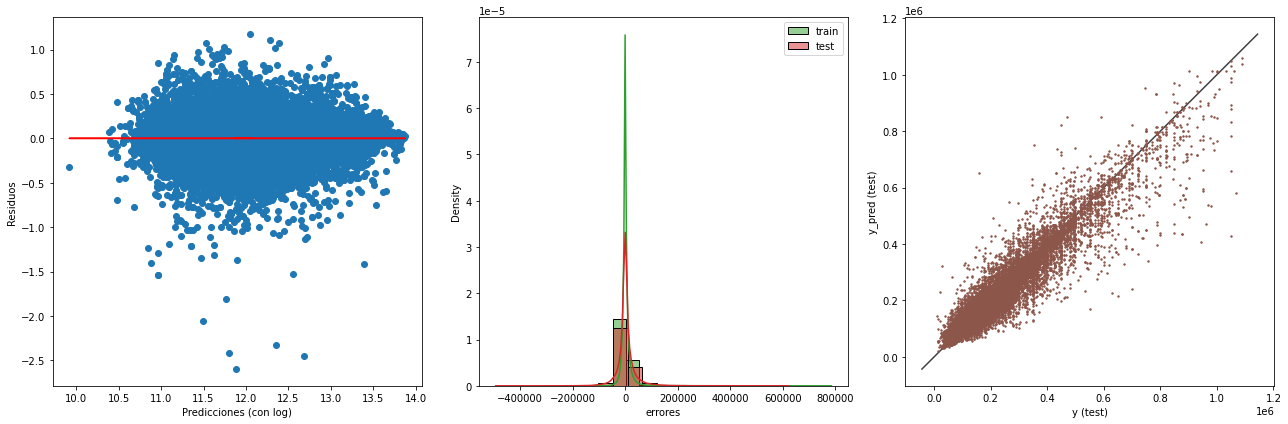

In [100]:
errores_rf = evaluar_regresion(rf, X_train, X_test, y_train, y_test)

RANDOMFORESTREGRESSOR(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CRITERION='MSE',
                      MAX_DEPTH=14, MAX_FEATURES='AUTO', MAX_LEAF_NODES=NONE,
                      MAX_SAMPLES=NONE, MIN_IMPURITY_DECREASE=0.0,
                      MIN_IMPURITY_SPLIT=NONE, MIN_SAMPLES_LEAF=1,
                      MIN_SAMPLES_SPLIT=2, MIN_WEIGHT_FRACTION_LEAF=0.0,
                      N_ESTIMATORS=100, N_JOBS=NONE, OOB_SCORE=FALSE,
                      RANDOM_STATE=NONE, VERBOSE=0, WARM_START=FALSE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  36405.78  44431.87 
MAE:   21097.02  25959.14 
R2:        0.92      0.88 


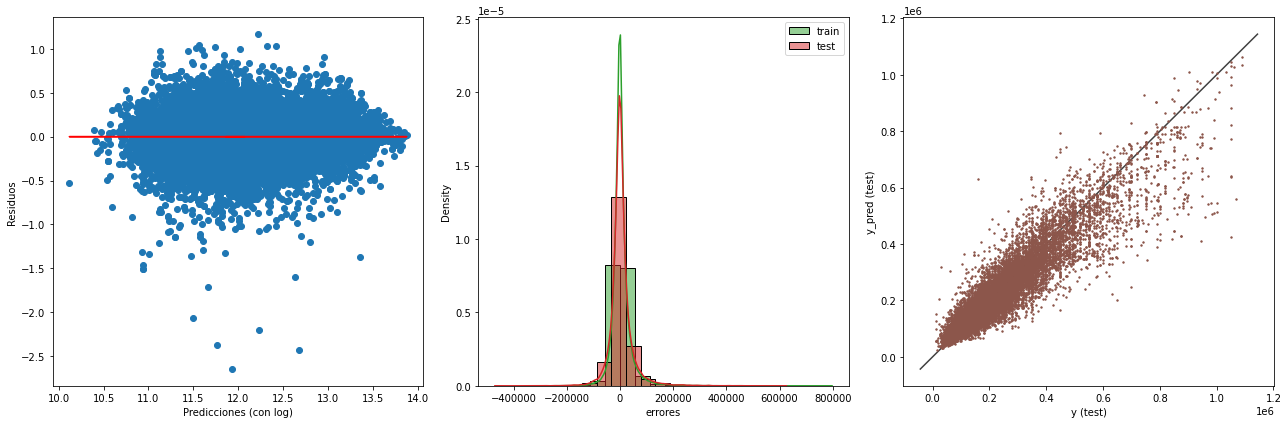

In [101]:
# Notamos que esta un poco over fitteado, intentamos regularizar el modelo determinando max_depth
# Instancio modelo con max_depth=14
rf_ = RandomForestRegressor(max_depth=14)
#Entrenar
rf_.fit(X_train,y_train);
errores_rf = evaluar_regresion(rf_, X_train, X_test, y_train, y_test)

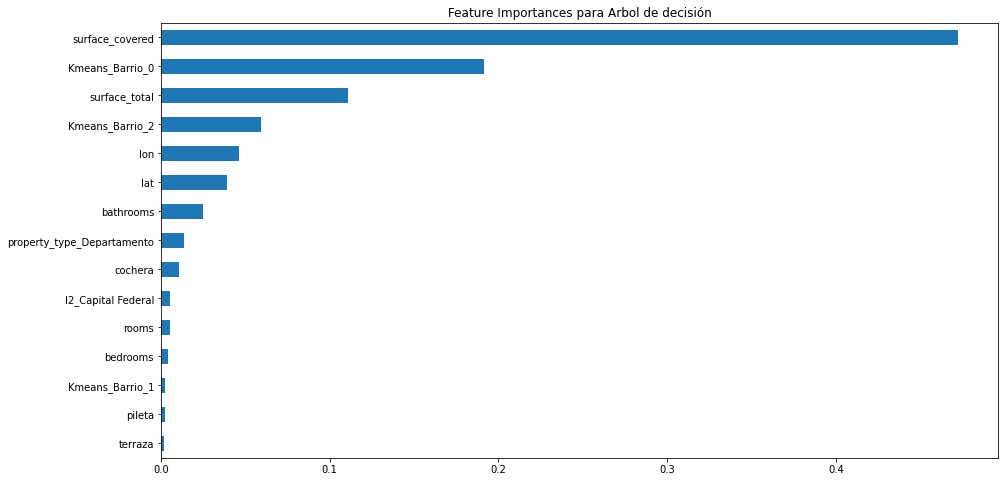

In [102]:
feat_importances = pd.Series(rf_.feature_importances_, index=[str(col) for col in data.columns if col!='price'])
feat_importances.nlargest(15).plot(kind='barh').invert_yaxis()
plt.title('Feature Importances para Arbol de decisión')
plt.show()

Vemos que 'surface_covered' es el atributo más importante, seguido de 'Kmeans_Barrio_0'.

Realizamos una optimización de hiperparámetros usando Random Search y Cross Validation.

{'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=  24.8s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.8s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=  24.8s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=  24.8s
[CV] n_estimators=160, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=160, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False, total= 2.6min
[CV] n_estimators=160, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=160, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False, total= 2.5min
[CV] n_estimators=160, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_es

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 12.9min finished


{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': False}
RANDOMIZEDSEARCHCV(CV=3, ERROR_SCORE=NAN,
                   ESTIMATOR=RANDOMFORESTREGRESSOR(BOOTSTRAP=TRUE,
                                                   CCP_ALPHA=0.0,
                                                   CRITERION='MSE',
                                                   MAX_DEPTH=NONE,
                                                   MAX_FEATURES='AUTO',
                                                   MAX_LEAF_NODES=NONE,
                                                   MAX_SAMPLES=NONE,
                                                   MIN_IMPURITY_DECREASE=0.0,
                                                   MIN_IMPURITY_SPLIT=NONE,
                                                   MIN_SAMPLES_LEAF=1,
                                                   MIN_SAMPLES_SPLIT=2,
                                                 

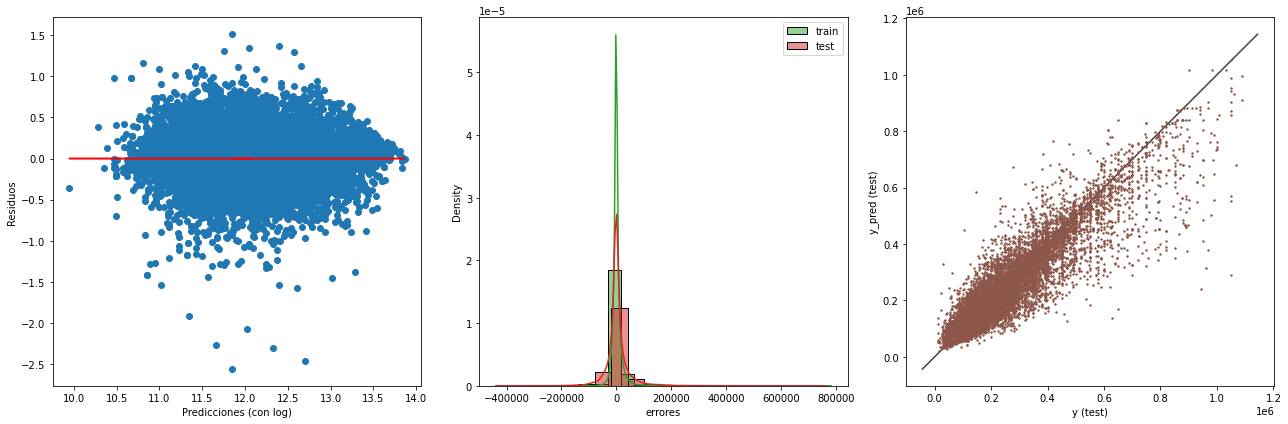

In [103]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca.drop(['price'], axis = 1), data_pca.price, test_size=0.33, random_state=42)

#ESTRATEGIA: Random Search datos con reducción dimensional pca

rf0 = RandomForestRegressor()

#Definimos los conjuntos (parámetro y rango de cada uno) para nuestra grilla:

# Número de árboles en el random forest:
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
# Número de features a considerar en cada split: 
max_features = ['auto', 'sqrt']
# Máximo número de niveles en el árbol:
max_depth = [int(x) for x in np.linspace(20, 100, num = 9)]
max_depth.append(None)
# Mínimo número de muestras requeridas para dividir/split un nodo:
min_samples_split = [2, 5, 10]
# Mínimo número de muestras requeridas en cada hoja:
min_samples_leaf = [1, 2, 4]
# Método para seleccionar las muestras para entrenar cada árbol:
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf0, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42) 

# Fit the random search model
rf_random.fit(X_train_pca, y_train_pca)

print(rf_random.best_params_)


errores_rf_random = evaluar_regresion(rf_random, X_train_pca, X_test_pca, y_train_pca, y_test_pca)


Seleccionamos algunos árboles y estudiamos qué atributos considera importantes:

In [104]:
print('Nuestro modelo usó ' + str(len(rf.estimators_)) + ' estimadores.')

Nuestro modelo usó 100 estimadores.


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1608637542, splitter='best')
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=3344769, splitter='best')


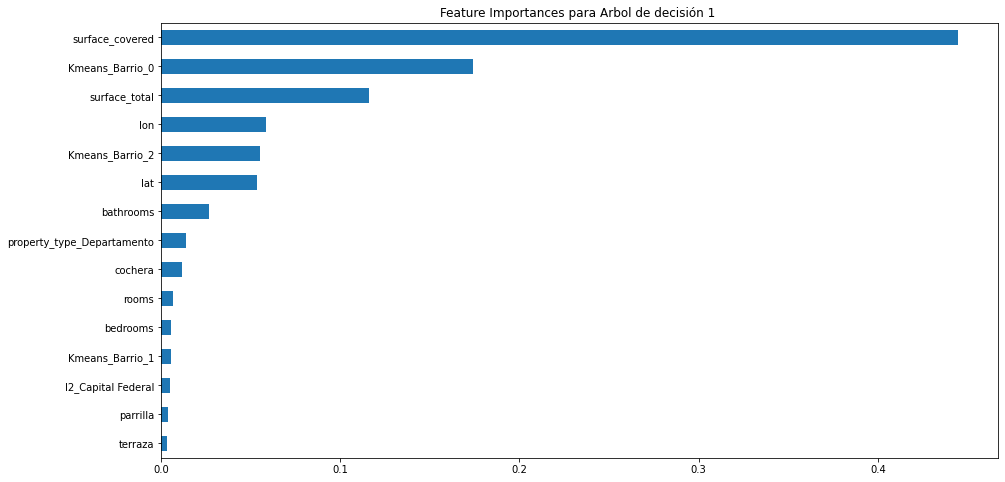

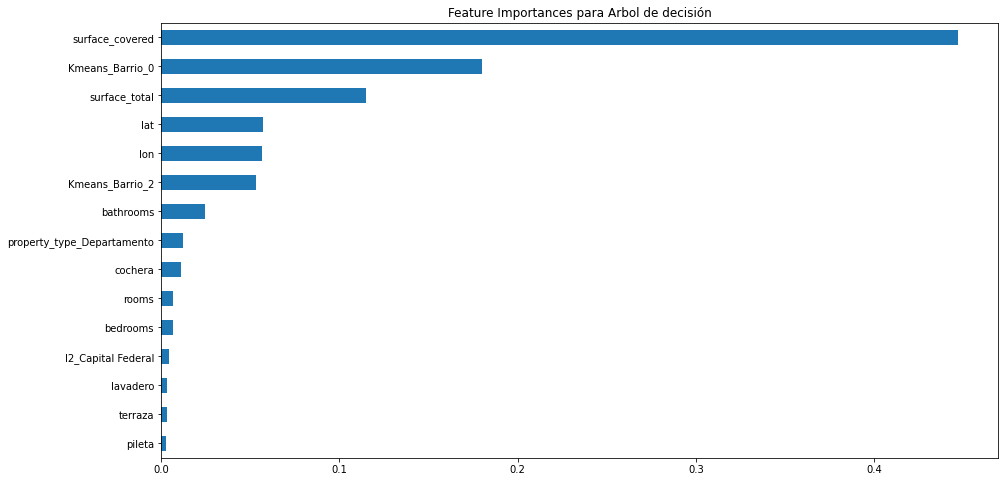

In [105]:
arbol1 = rf.estimators_[0]
arbol2 = rf.estimators_[27]

print(arbol1)
print(arbol2)

feat_importances = pd.Series(arbol1.feature_importances_, index=[str(col) for col in data.columns if col!='price'])
feat_importances.nlargest(15).plot(kind='barh').invert_yaxis()
plt.title('Feature Importances para Arbol de decisión 1 ')
plt.show()

feat_importances = pd.Series(arbol2.feature_importances_, index=[str(col) for col in data.columns if col!='price'])
feat_importances.nlargest(15).plot(kind='barh').invert_yaxis()
plt.title('Feature Importances para Arbol de decisión')
plt.show()


Podemos ver que los primero tres atributos más importantes coinciden tanto para Random Forest como para los dos árboles seleccionados aleatoriamente. Sin embargo no coincide el orden de importancia en los tres gráficos. El hecho de que superficie cubierta sea el atributo más importante coincide con el hecho de que el tamaño de la propiedad es determinante para definir el precio de la misma. Vemos que también tienen considerable importancia atributos relacionados a la ubicación de las propiedades como también era esperado. 

Además vemos que estos dos árboles se diferencian en el parámetro random_state.

## XGboost

In [106]:
import xgboost as xgb

In [107]:
X_train_xgb1, X_test_xgb1 = train_test_split(data, test_size=.3, random_state=1999)

In [108]:
X_train_xgb = xgb.DMatrix(X_train_xgb1.drop(['price'], axis= 1), label=X_train_xgb1['price'])
X_test_xgb = xgb.DMatrix(X_test_xgb1.drop(['price'], axis = 1), label=X_test_xgb1['price'])

In [109]:
X_train_xgb

In [110]:
parametros = {"booster":"gbtree", "max_depth": 15, "eta": 0.3, "nthread":3}
rondas = 20

In [111]:
modelo = xgb.train(parametros, X_train_xgb, rondas)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


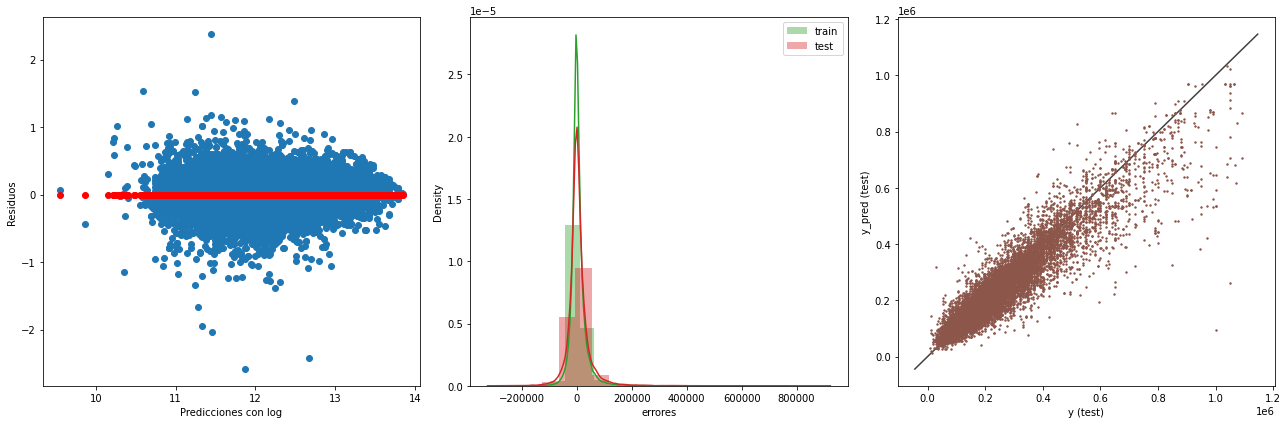

In [112]:
prediccion = modelo.predict(X_test_xgb)
prediccion_train = modelo.predict(X_train_xgb)
expy_train = np.exp(X_train_xgb1['price'])
expy_train_pred = np.exp(prediccion_train)
expy_test = np.exp(X_test_xgb1['price'])
expy_test_pred = np.exp(prediccion)

### GRAFICAMOS LOS RESULTADOS
plt.figure(figsize = (18,6))
plt.subplot(1,3,1)
residuals_xgb = X_test_xgb1['price']-prediccion

plt.scatter(prediccion, residuals_xgb)
plt.scatter(prediccion, np.zeros(len(prediccion)),c='r')
plt.xlabel('Predicciones con log')
plt.ylabel('Residuos')
   
# stat="density"
plt.subplot(1,3,2)
sns.distplot((expy_train - expy_train_pred), bins = 20, label = 'train', color='C2', kde= True)
sns.distplot((expy_test - expy_test_pred), bins = 20, label = 'test', color='C3', kde = True)
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,3,3)
ax.scatter(expy_test,expy_test_pred, s =2,c='C5')

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
       ]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show();

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


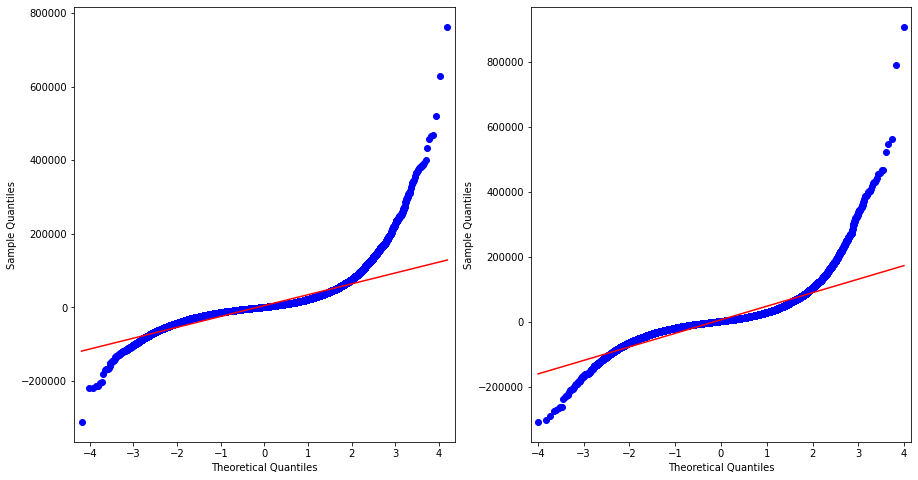

In [113]:
import statsmodels.api as sm
import pylab
fig, (ax, ax2) = plt.subplots(ncols=2) # create two subplots, one in each row
sm.qqplot(expy_train - expy_train_pred, ax=ax, line='s' )
sm.qqplot(expy_test - expy_test_pred,ax=ax2, line='s')
pylab.show()

En ambos casos la distribución tiene colas más pesadas que la normal.

In [114]:
rmse_train = np.sqrt(mean_squared_error(np.exp(X_train_xgb1['price']), np.exp(prediccion_train)))
mae_train = mean_absolute_error(np.exp(X_train_xgb1['price']), np.exp(prediccion_train))
r2_train = r2_score(np.exp(X_train_xgb1['price']), np.exp(prediccion_train))
print(str(modelo).upper())
print("ERROR  TRAIN    ")
print("------ ---------")
print("%-7s %-9.2f  "%('RECM:',rmse_train))
print("%-7s %-9.2f  "%('MAE:',mae_train))
print("%-10s %-9.2f  "%('R2:',r2_train))

rmse_test = np.sqrt(mean_squared_error(np.exp(X_test_xgb1['price']), np.exp(prediccion)))
mae_test = mean_absolute_error(np.exp(X_test_xgb1['price']), np.exp(prediccion))
r2_test = r2_score(np.exp(X_test_xgb1['price']), np.exp(prediccion))
print(str(modelo).upper())
print("ERROR  TEST    ")
print("------ --------")
print("%-6s %-9.2f  "%('RECM:',rmse_test))
print("%-6s %-9.2f  "%('MAE:',mae_test))
print("%-10s %-9.2f  "%('R2:',r2_test))

<XGBOOST.CORE.BOOSTER OBJECT AT 0X7FA054B15E10>
ERROR  TRAIN    
------ ---------
RECM:   29954.74   
MAE:    17490.02   
R2:        0.94       
<XGBOOST.CORE.BOOSTER OBJECT AT 0X7FA054B15E10>
ERROR  TEST    
------ --------
RECM:  42081.76   
MAE:   24172.39   
R2:        0.89       


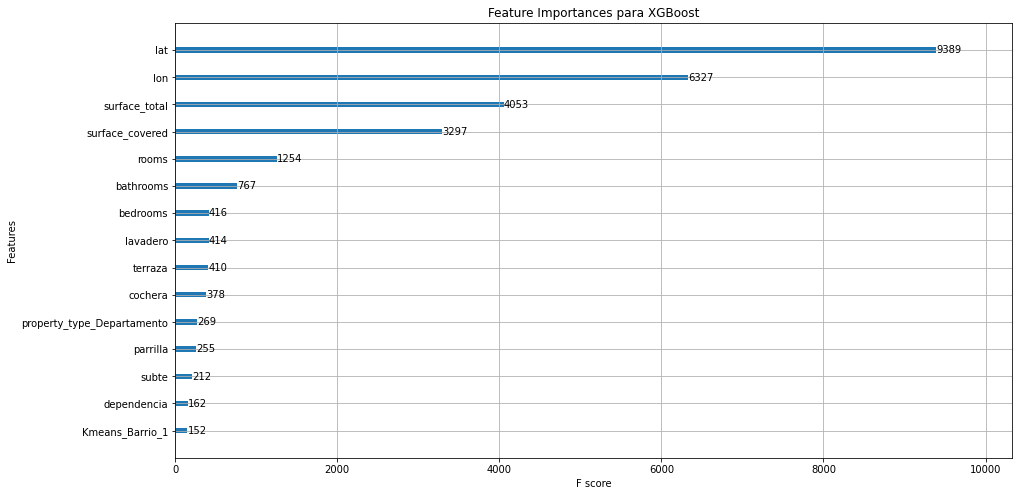

In [115]:
plt.rcParams['figure.figsize'] = (15,8)
xgb.plot_importance(modelo,max_num_features=15, title='Feature Importances para XGBoost')

In [116]:
##for tuning parameters
#parameters_for_testing = {
#    'colsample_bytree':[0.4,0.6,0.8],
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.3,0.1,0.07],
#    'max_depth':[13,15],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6,0.95]  
#}

                    
#xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=800, max_depth=10,
#     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=3, scale_pos_weight=1, seed=27)


#rsearch1 = RandomizedSearchCV(estimator = xgb_model, param_distributions = parameters_for_testing, n_iter = 5, n_jobs=-1, verbose=10, cv = 3, scoring='neg_mean_absolute_error')
#rsearch1.fit(X_train_pca,y_train_pca)

#print('best params')
#print(rsearch1.best_params_)
#print('best score')
#print(rsearch1.best_score_)

Resultado de correr el bloque de código anterior (dejamos comentado para no volver a correr - demoró 46.5min) y copiamos sus prints a continuación:



```
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 23.6min finished
[14:18:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best params
{'subsample': 0.95, 'reg_lambda': 0.45, 'reg_alpha': 1e-05, 'min_child_weight': 10, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.03, 'colsample_bytree': 0.4}
best score
-0.139097369768662
```



[17:52:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBREGRESSOR(BASE_SCORE=0.5, BOOSTER='GBTREE', COLSAMPLE_BYLEVEL=1,
             COLSAMPLE_BYNODE=1, COLSAMPLE_BYTREE=0.4, GAMMA=0.03,
             IMPORTANCE_TYPE='GAIN', LEARNING_RATE=0.1, MAX_DELTA_STEP=0,
             MAX_DEPTH=15, MIN_CHILD_WEIGHT=10, MISSING=NONE, N_ESTIMATORS=800,
             N_JOBS=1, NTHREAD=NONE, OBJECTIVE='REG:LINEAR', RANDOM_STATE=0,
             REG_ALPHA=1E-05, REG_LAMBDA=0.45, SCALE_POS_WEIGHT=1, SEED=27,
             SILENT=NONE, SUBSAMPLE=0.95, VERBOSITY=1)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  21373.87  46055.37 
MAE:   11558.20  24443.41 
R2:        0.97      0.87 


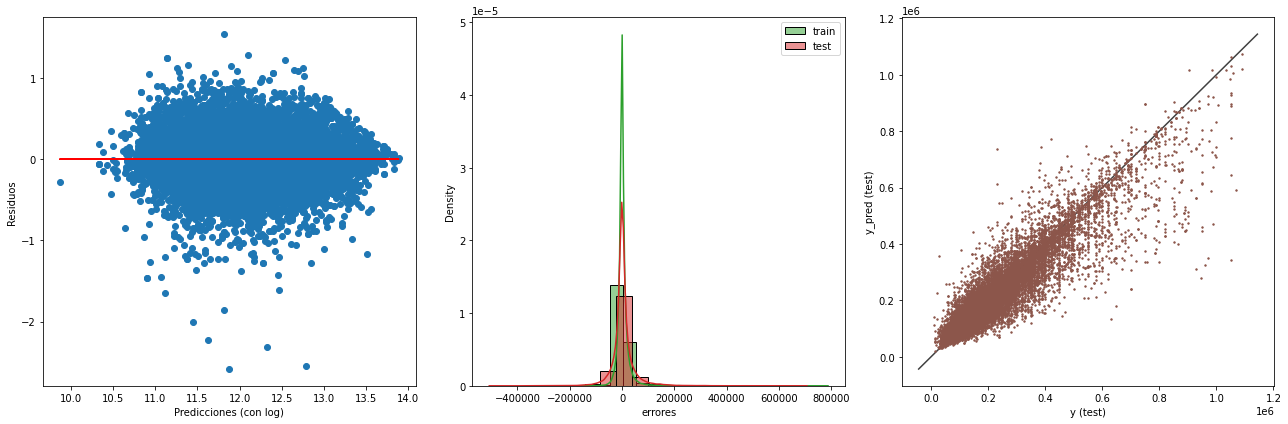

In [117]:
best_xgb_model = xgb.XGBRegressor(colsample_bytree= 0.4,
                 gamma=0.03,                 
                 learning_rate=0.1,
                 max_depth=15,
                 min_child_weight=10,
                 n_estimators=800,                                                                    
                 reg_alpha=1e-05,
                 reg_lambda=0.45,
                 subsample=0.95,
                 seed=27)
best_xgb_model.fit(X_train_pca,y_train_pca)

errores_xgb_gs = evaluar_regresion(best_xgb_model, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

# PARTE C - Comparación entre modelos e Interpretación

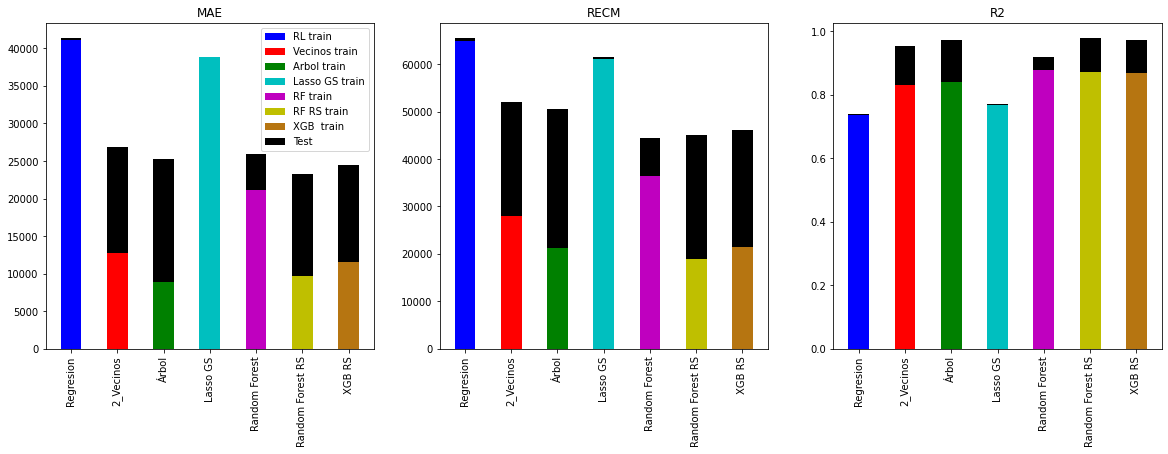

In [118]:
mae = [errores_regr['MAE'][1],errores_2v['MAE'][1],errores_arbol['MAE'][1], errores_lasso_gs['MAE'][1], errores_rf['MAE'][1], errores_rf_random['MAE'][1], errores_xgb_gs['MAE'][1] ]
recm = [errores_regr['RECM'][1],errores_2v['RECM'][1],errores_arbol['RECM'][1], errores_lasso_gs['RECM'][1], errores_rf['RECM'][1], errores_rf_random['RECM'][1], errores_xgb_gs['RECM'][1] ]
r2 = [errores_regr['R2'][1],errores_2v['R2'][1],errores_arbol['R2'][1], errores_lasso_gs['R2'][1], errores_rf['R2'][1], errores_rf_random['R2'][1], errores_xgb_gs['R2'][1] ]
mae_train = [errores_regr['MAE'][0]-errores_regr['MAE'][1], errores_2v['MAE'][0]-errores_2v['MAE'][1], errores_arbol['MAE'][0]-errores_arbol['MAE'][1], errores_lasso_gs['MAE'][0]-errores_lasso_gs['MAE'][1], errores_rf['MAE'][0]-errores_rf['MAE'][1], errores_rf_random['MAE'][0]-errores_rf_random['MAE'][1], errores_xgb_gs['MAE'][0]-errores_xgb_gs['MAE'][1]]
recm_train = [errores_regr['RECM'][0]-errores_regr['RECM'][1], errores_2v['RECM'][0]-errores_2v['RECM'][1], errores_arbol['RECM'][0]-errores_arbol['RECM'][1], errores_lasso_gs['RECM'][0]-errores_lasso_gs['RECM'][1], errores_rf['RECM'][0]-errores_rf['RECM'][1], errores_rf_random['RECM'][0]-errores_rf_random['RECM'][1], errores_xgb_gs['RECM'][0]-errores_xgb_gs['RECM'][1]]
r2_train = [errores_regr['R2'][0]-errores_regr['R2'][1], errores_2v['R2'][0]-errores_2v['R2'][1], errores_arbol['R2'][0]-errores_arbol['R2'][1], errores_lasso_gs['R2'][0]-errores_lasso_gs['R2'][1], errores_rf['R2'][0]-errores_rf['R2'][1], errores_rf_random['R2'][0]-errores_rf_random['R2'][1], errores_xgb_gs['R2'][0]-errores_xgb_gs['R2'][1]]

ticks_x =('Regresion', '2_Vecinos', 'Árbol', 'Lasso GS', 'Random Forest', 'Random Forest RS', 'XGB RS')
color = ('b','r','g', 'c', 'm', 'y', '#b67511')
width = 0.45
x=np.arange(7)   
### GRAFICAMOS LOS RESULTADOS
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
p =plt.bar(x,mae,color=color,width=width)
p2 = plt.bar(x,mae_train,width=width,bottom=mae,color='k')
plt.legend((p[0],p[1],p[2],p[3],p[4],p[5],p[6],p2[0]), ('RL train','Vecinos train', 'Arbol train','Lasso GS train', 'RF train', 'RF RS train', 'XGB  train','Test'))
plt.title('MAE')
plt.xticks(x,ticks_x, rotation='vertical')
plt.subplot(1,3,2)
plt.bar(x,recm,color=color,width=width)
plt.bar(x,recm_train,width=width,bottom=recm,color='k')
plt.title('RECM')
plt.xticks(x,ticks_x, rotation='vertical')
plt.subplot(1,3,3)
plt.bar(x,r2,width=width,color=color)
plt.bar(x,r2_train,width=width,bottom=r2,color='k')
plt.title('R2')
plt.xticks(x,ticks_x, rotation='vertical')


plt.show()

In [119]:
l1=[errores_regr[key][0].round(2) for key in errores_regr.keys()]
l2=[errores_2v[key][0].round(2) for key in errores_2v.keys()]
l3=[errores_arbol[key][0].round(2) for key in errores_arbol.keys()]
l4=[errores_lasso_gs[key][0].round(2) for key in errores_lasso_gs.keys()]
l5=[errores_rf[key][0].round(2) for key in errores_rf.keys()]
l6=[errores_rf_random[key][0].round(2) for key in errores_rf_random.keys()]
l7=[errores_xgb_gs[key][0].round(2) for key in errores_xgb_gs.keys()]
names=['Regresión', '2-vecinos', 'Árbol', 'Lasso', 'Ranfom Forest', 'Random Forest RS', 'XGB RS']
df_errores_train = pd.DataFrame(np.array([l1,l2,l3,l4,l5,l6,l7]), columns=['RECM','MAE','R2'])
df_errores_train.insert(0,'Regresor',names,True)
print('Errores en train')
print(df_errores_train)
l1=[errores_regr[key][1].round(2) for key in errores_regr.keys()]
l2=[errores_2v[key][1].round(2) for key in errores_2v.keys()]
l3=[errores_arbol[key][1].round(2) for key in errores_arbol.keys()]
l4=[errores_lasso_gs[key][1].round(2) for key in errores_lasso_gs.keys()]
l5=[errores_rf[key][1].round(2) for key in errores_rf.keys()]
l6=[errores_rf_random[key][1].round(2) for key in errores_rf_random.keys()]
l7=[errores_xgb_gs[key][1].round(2) for key in errores_xgb_gs.keys()]

df_errores_test = pd.DataFrame(np.array([l1,l2,l3,l4,l5,l6,l7]), columns=['RECM','MAE','R2'])
df_errores_test.insert(0,'Regresor',names,True)
print('Errores en test')
print(df_errores_test)

Errores en train
           Regresor      RECM       MAE    R2
0         Regresión  65468.85  41342.22  0.74
1         2-vecinos  27955.42  12751.17  0.95
2             Árbol  21180.00   8926.40  0.97
3             Lasso  61399.74  38858.98  0.77
4     Ranfom Forest  36405.78  21097.02  0.92
5  Random Forest RS  18865.04   9635.33  0.98
6            XGB RS  21373.87  11558.20  0.97
Errores en test
           Regresor      RECM       MAE    R2
0         Regresión  64907.26  41105.97  0.74
1         2-vecinos  52012.51  26869.81  0.83
2             Árbol  50645.58  25262.57  0.84
3             Lasso  61126.35  38789.30  0.77
4     Ranfom Forest  44431.87  25959.14  0.88
5  Random Forest RS  45152.76  23219.87  0.87
6            XGB RS  46055.37  24443.41  0.87


In [136]:
print(df_errores_test.Regresor[df_errores_test.MAE == df_errores_test.MAE.min()])
print(df_errores_test.MAE.min())

5    Random Forest RS
Name: Regresor, dtype: object
23219.87


In [121]:
print('Porcentaje de error en Test para el modelo Random Forest con RandomSearch es: '+'%.2f'%((23213.17*100)/194732.57)+'%.')

Porcentaje de error en Test para el modelo Random Forest con RandomSearch es: 11.92%.


Por lo visto anteriormente, el modelo de Random Forest que obtuvimos con el método de RandomSearch es el que arroja el mejor rendimiento en test en la métrica MAE. Vemos que representa casi un 12% del valor promedio de las propiedades del dataset. De todas formas, notamos que la diferencia en la performance del modelo entre las etapas de train y test es considerable. En términos de sesgo y varianza, el modelo tiene mejor rendimiento en términos de sesgo y peor rendimiento en términos de varianza. Los modelos que desempeñan mejor en términos de varianza son Regresión lineal y regresión Lasso con atributos polinomicos, pero estos modelos ne desempeñan bien en sesgo comparando con Random Forest.

Si tuvieramos que seleccionar un único modelo, podemos elegir el primer Random Forest (sin RandomSearch en color magenta en el gráfico) que tiene valores similares al Random Forest con RandomSearch pero tiene mejor desempeño en términos de varianza.

Observamos que los errores de los modelos se distribuyen normalmente en torno a cero. Hay heterocedasticidad a mayores precios de las propiedades y como vimos en el qqplot las distribuciones de errores tienen colas más pesadas que la normal. Como mejoras podemos proponer mejorar el preprocesamiento o continuar el trabajo de análisis de modelos. De todos modos, la mejora frente a los resultados del Proyecto_01 es notable.


## Neural Network

Finalmente trabajamos con una primera aproximación a redes neuronales con TensorFlow, como una posilbe línea que continua el trabajo realizado.

In [122]:
import tensorflow as tf

In [123]:
model = tf.keras.Sequential()

In [124]:
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [125]:
model.compile(loss='mean_absolute_error', optimizer='adam')

In [126]:
X = data

In [127]:
scaler_tf = MinMaxScaler(feature_range=(0, 1))
# Scale both the training inputs and outputs
scaled_train = scaler_tf.fit_transform(X)
#scaled_test = scaler.transform(test_df)

# Print out the adjustment that the scaler applied to the total_earnings column of data
print("Note: price were scaled by multiplying by {:.10f} and adding {:.6f}".format(scaler_tf.scale_[7], scaler_tf.min_[7]))

multiplied_by = scaler_tf.scale_[7]
added = scaler_tf.min_[7]

scaled_train_df = pd.DataFrame(scaled_train, columns=X.columns.values)

Note: price were scaled by multiplying by 0.2130750948 and adding -1.962494


In [128]:
X = scaled_train_df.drop(['price'], axis=1).values
Y = scaled_train_df['price'].values

In [129]:
# Train the model
model.fit(
    X[10000:],
    Y[10000:],
    epochs=50,
    shuffle=True,
    verbose=2
)

Epoch 1/50
2898/2898 - 4s - loss: 0.0447
Epoch 2/50
2898/2898 - 3s - loss: 0.0407
Epoch 3/50
2898/2898 - 3s - loss: 0.0400
Epoch 4/50
2898/2898 - 3s - loss: 0.0393
Epoch 5/50
2898/2898 - 3s - loss: 0.0392
Epoch 6/50
2898/2898 - 3s - loss: 0.0388
Epoch 7/50
2898/2898 - 3s - loss: 0.0385
Epoch 8/50
2898/2898 - 3s - loss: 0.0384
Epoch 9/50
2898/2898 - 3s - loss: 0.0382
Epoch 10/50
2898/2898 - 3s - loss: 0.0381
Epoch 11/50
2898/2898 - 3s - loss: 0.0379
Epoch 12/50
2898/2898 - 3s - loss: 0.0377
Epoch 13/50
2898/2898 - 3s - loss: 0.0376
Epoch 14/50
2898/2898 - 3s - loss: 0.0375
Epoch 15/50
2898/2898 - 3s - loss: 0.0373
Epoch 16/50
2898/2898 - 3s - loss: 0.0373
Epoch 17/50
2898/2898 - 3s - loss: 0.0372
Epoch 18/50
2898/2898 - 3s - loss: 0.0370
Epoch 19/50
2898/2898 - 3s - loss: 0.0370
Epoch 20/50
2898/2898 - 3s - loss: 0.0368
Epoch 21/50
2898/2898 - 3s - loss: 0.0367
Epoch 22/50
2898/2898 - 3s - loss: 0.0367
Epoch 23/50
2898/2898 - 3s - loss: 0.0365
Epoch 24/50
2898/2898 - 3s - loss: 0.0365
E

In [130]:
test_error_rate = model.evaluate(X[:10000], Y[:10000], verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

The mean squared error (MSE) for the test data set is: 0.03673887625336647


In [131]:
prediction = model.predict(X[:10000])

In [132]:
prediction -= added
prediction /= multiplied_by

In [133]:
print('Neural net - logaritmo en price:')
print('RECM:', np.sqrt(mean_squared_error(np.exp(data.price[:10000]) , np.exp(prediction))).round(3))
print('MAE:', (mean_absolute_error(np.exp(data.price[:10000]) , np.exp(prediction))).round(3))
print('R2:', r2_score(np.exp(data.price[:10000]) , np.exp(prediction)).round(3))

Neural net - logaritmo en price:
RECM: 50501.762
MAE: 31513.938
R2: 0.824
